## Importing and linking databases

## Movies

In [140]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import re
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
import pgeocode
from sklearn.preprocessing import StandardScaler
import gensim.downloader as api
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Dropout, Concatenate, Flatten, Lambda
from tensorflow.keras.models import Model, Sequential
from sklearn.decomposition import PCA
import umap

In [141]:
movies_lens_ratings = pd.read_csv("ml-100k/u1.base",sep='\t',header=None, names=["userId", "movieId", "rating", "timestamp"])

In [142]:
movies_lens_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [143]:
movies_lens_items = pd.read_csv("ml-100k/u.item",
                    sep='|',
                    header=None,
                    encoding="latin1",
                    names=["id", "title", "date released", "video_release_date", "link", "unknown", 
    "Action", 
    "Adventure", 
    "Animation", 
    "Children's", 
    "Comedy", 
    "Crime", 
    "Documentary", 
    "Drama", 
    "Fantasy", 
    "Film-Noir", 
    "Horror", 
    "Musical", 
    "Mystery", 
    "Romance", 
    "Sci-Fi", 
    "Thriller", 
    "War", 
    "Western"])

In [144]:
movies_lens_items.head()

,id,title,date released,video_release_date,link,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [145]:
movies_lens_items['mod_year'] = movies_lens_items['title'].str.extract(r'\((\d{4})\)')[0].astype('Int64')
movies_lens_items['title'] = movies_lens_items['title'].str.extract(r'^(.*) \((\d{4})\)$')[0]
movies_lens_items['release_year'] = pd.to_datetime(movies_lens_items['date released'], format='%d-%b-%Y').dt.year.astype('Int64')
movies_lens_items = movies_lens_items.drop(['date released', 'video_release_date', 'link'], axis=1)

In [146]:
mismatched_years = movies_lens_items[movies_lens_items['mod_year'] != movies_lens_items['release_year']]

In [147]:
mismatched_years

,id,title,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,mod_year,release_year
9,10,Richard III,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1995,1996
14,15,Mr. Holland's Opus,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1995,1996
21,22,Braveheart,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1995,1996
22,23,Taxi Driver,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1976,1996
23,24,Rumble in the Bronx,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1995,1996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1668,1669,MURDER and murder,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,1996,1997
1670,1671,"Further Gesture, A",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1996,1998
1676,1677,Sweet Nothing,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1995,1996
1677,1678,Mat' i syn,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1997,1998


In [148]:
#movies_lens_items = movies_lens_items.drop('mod_year', axis=1)

In [149]:
movies_lens_items.columns

Index(['id', 'title', 'unknown', 'Action', 'Adventure', 'Animation',
       'Children's', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
       'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
       'Thriller', 'War', 'Western', 'mod_year', 'release_year'],
      dtype='object')

In [150]:
#Find commas -> might need to fix title
commas = movies_lens_items[movies_lens_items['title'].str.contains(',', na=False)]
commas.head(75)

,id,title,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,mod_year,release_year
11,12,"Usual Suspects, The",0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,1995,1995
13,14,"Postino, Il",0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1994,1994
17,18,"White Balloon, The",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1995,1995
24,25,"Birdcage, The",0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1996,1996
25,26,"Brothers McMullen, The",0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1995,1995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,305,"Ice Storm, The",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1997,1997
305,306,"Mrs. Brown (Her Majesty, Mrs. Brown)",0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1997,1997
306,307,"Devil's Advocate, The",0,0,0,0,0,0,1,0,...,1,0,1,0,0,1,0,0,1997,1997
309,310,"Rainmaker, The",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1997,1997


In [151]:
def fix_title(title):
    if not isinstance(title, str) or title.strip() == '':
        return title
    #translated titles
    title = re.sub(r'\s*\([^()]*\)$', '', title)
    
    # Revered titles
    title = re.sub(r'^(.*?),\s(The|A|An|Il|La|Le|Les|L\'|Der|Das)$', r'\2 \1', title)
    
    return title.strip()

movies_lens_items['title'] = movies_lens_items['title'].fillna('').astype(str).apply(fix_title)
movies_lens_items = movies_lens_items.drop_duplicates(subset=['title', 'release_year'])
movies_lens_items = movies_lens_items.drop_duplicates(subset=['id'])

In [152]:
movies_lens_items.shape

(1663, 23)

In [153]:
links = pd.read_csv("movie-data/links.csv", sep=',')
links = links.rename(columns={'movieId': 'id'})

In [154]:
links.head()

,id,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [155]:
movie_data_items = pd.read_csv("movie-data/movies_metadata.csv", sep=',', encoding="latin1")

In [156]:
movie_data_items.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173


In [157]:
movie_data_items['release_year'] = pd.to_datetime(movie_data_items['release_date'], errors='coerce').dt.year.astype('Int64')
movie_data_items_title_mismatch = movie_data_items[movie_data_items['original_title'] != movie_data_items['title']]

In [158]:
movie_data_items_title_mismatch.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,release_year
28,False,NaN,18000000,"[{'id': 14, 'name': 'Fantasy'}, {'id': 878, 'n...",NaN,902,tt0112682,fr,La CitÃ© des Enfants Perdus,A scientist in a surrealist society kidnaps ch...,...,1738611,108.0,"[{'iso_639_1': 'cn', 'name': 'å¹¿å·è¯ / å»£å...",Released,Where happily ever after is just a dream.,The City of Lost Children,False,7.6,308,1995
29,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",NaN,37557,tt0115012,zh,æåæï¼æå°å¤å©æ¡¥,A provincial boy related to a Shanghai crime f...,...,0,108.0,"[{'iso_639_1': 'zh', 'name': 'æ®éè¯'}]",Released,In 1930's Shanghai violence was not the proble...,Shanghai Triad,False,6.5,17,1995
32,False,NaN,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 12, ...",NaN,78802,tt0114952,fr,"Guillaumet, les ailes du courage",NaN,...,0,50.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Wings of Courage,False,6.8,4,1996
57,False,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,11010,tt0110877,it,Il postino,Simple Italian postman learns to love poetry w...,...,0,108.0,"[{'iso_639_1': 'it', 'name': 'Italiano'}, {'is...",Released,NaN,The Postman,False,7.6,181,1994
58,False,NaN,0,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",NaN,99040,tt0112714,fr,Le confessionnal,"The year is 1952, in Quebec City. Rachel (16),...",...,0,100.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,The Confessional,False,6.5,2,1995


In [159]:
movie_data_items = movie_data_items.drop(['original_title', 'homepage', 'release_date', 'status', 'video', 'poster_path', 'adult', 'belongs_to_collection', 'release_date'], axis=1)

In [160]:
movies_lens_items

,id,title,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,mod_year,release_year
0,1,Toy Story,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,1995,1995
1,2,GoldenEye,0,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1995,1995
2,3,Four Rooms,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1995,1995
3,4,Get Shorty,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1995,1995
4,5,Copycat,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,1995,1995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1676,1677,Sweet Nothing,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1995,1996
1677,1678,Mat' i syn,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1997,1998
1678,1679,B. Monkey,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,1998,1998
1680,1681,You So Crazy,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1994,1994


In [161]:
movie_data_items['imdb_id'] = movie_data_items['imdb_id'].str.replace('^tt', '', regex=True).astype('Int64')


In [162]:
movies_lens_items = pd.merge(
    movies_lens_items,
    links,
    on='id',
    how='left',
    suffixes=('', '_link')
)

In [163]:
movies_lens_items.head()

,id,title,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,mod_year,release_year,imdbId,tmdbId
0,1,Toy Story,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,1995,1995,114709.0,862.0
1,2,GoldenEye,0,1,1,0,0,0,0,0,...,0,0,0,1,0,0,1995,1995,113497.0,8844.0
2,3,Four Rooms,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1995,1995,113228.0,15602.0
3,4,Get Shorty,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1995,1995,114885.0,31357.0
4,5,Copycat,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,1995,1995,113041.0,11862.0


In [164]:
movie_data_merged = pd.merge(
    movie_data_items,
    links,
    on='id',
    how='left',
    suffixes=('', '_link')
)

# Find unmatched rows
unmatched_mask = movie_data_merged['imdbId'].isna()
unmatched_movies = movie_data_items[movie_data_items['id'].isin(movie_data_merged[unmatched_mask]['id'])]

# Try matching unmatched rows using imdb_id to imdbId
second_merge = pd.merge(
    unmatched_movies,
    links,
    left_on='imdb_id',
    right_on='imdbId',
    how='left',
    suffixes=('', '_link')
)

# Combine matched and newly matched rows
movie_data_final = pd.concat([
    movie_data_merged[~unmatched_mask],  # Successfully matched on id
    second_merge  # Matched on imdb_id or still unmatched
], ignore_index=True)

# Clean up duplicate columns
columns_to_drop = [col for col in movie_data_final.columns if col.endswith('_link')]
movie_data_items = movie_data_final.drop(columns=columns_to_drop)
movie_data_items = movie_data_items.rename(columns={'id': 'data_id'})

In [165]:
movie_data_items

,budget,genres,data_id,imdb_id,original_language,overview,popularity,production_companies,production_countries,revenue,runtime,spoken_languages,tagline,title,vote_average,vote_count,release_year,imdbId,tmdbId
0,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,114709,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",373554033,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",NaN,Toy Story,7.7,5415,1995,116985.0,88224.0
1,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,113497,en,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",262797249,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Roll the dice and unleash the excitement!,Jumanji,6.9,2413,1995,78763.0,42164.0
2,60000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",949,113277,en,"Obsessive master thief, Neil McCauley leads a ...",17.924927,"[{'name': 'Regency Enterprises', 'id': 508}, {...","[{'iso_3166_1': 'US', 'name': 'United States o...",187436818,170.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",A Los Angeles Crime Saga,Heat,7.7,1886,1995,48028.0,220.0
3,58000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",710,113189,en,James Bond must unmask the mysterious head of ...,14.686036,"[{'name': 'United Artists', 'id': 60}, {'name'...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",352194034,130.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",No limits. No fears. No substitutes.,GoldenEye,6.6,1194,1995,115851.0,23449.0
4,98000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",1408,112760,en,"Morgan Adams and her slave, William Shaw, are ...",7.284477,"[{'name': 'Le Studio Canal+', 'id': 183}, {'na...","[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",10017322,119.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",The Course Has Been Set. There Is No Turning B...,Cutthroat Island,5.7,137,1995,104691.0,9361.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45459,0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",30840,102797,en,"Yet another version of the classic epic, with ...",5.683753,"[{'name': 'Westdeutscher Rundfunk (WDR)', 'id'...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",NaN,Robin Hood,5.7,26,1991,102797.0,30840.0
45460,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",439050,6209470,fa,Rising and falling between a man and woman.,0.072051,[],"[{'iso_3166_1': 'IR', 'name': 'Iran'}]",0,90.0,"[{'iso_639_1': 'fa', 'name': 'ÙØ§Ø±Ø³Û'}]",Rising and falling between a man and woman,Subdue,4.0,1,<NA>,6209470.0,439050.0
45461,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",67758,303758,en,"When one of her hits goes wrong, a professiona...",0.903007,"[{'name': 'American World Pictures', 'id': 6165}]","[{'iso_3166_1': 'US', 'name': 'United States o...",0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",A deadly game of wits.,Betrayal,3.8,6,2003,303758.0,67758.0
45462,0,[],227506,8536,en,"In a small town live two brothers, one a minis...",0.003503,"[{'name': 'Yermoliev', 'id': 88753}]","[{'iso_3166_1': 'RU', 'name': 'Russia'}]",0,87.0,[],NaN,Satan Triumphant,0.0,0,1917,8536.0,227506.0


In [166]:
# 1. Try merging on title+release_year
merged_step1 = pd.merge(
    movies_lens_items,
    movie_data_items,
    on=["title", "release_year"],
    how="left",
    suffixes=("", "_md")
)

# unmatched
mask_unmatched = merged_step1["imdb_id"].isna()
unmatched_df = movies_lens_items[movies_lens_items["id"].isin(merged_step1[mask_unmatched]["id"])]

# 2. merge title+mod_year instead
merged_step2 = pd.merge(
    unmatched_df,
    movie_data_items,
    left_on=["title", "mod_year"],
    right_on=["title", "release_year"],
    how="left",
    suffixes=("", "_md")
)

# still unmatched
mask_still_unmatched = merged_step2["imdb_id"].isna()
still_unmatched_df = unmatched_df[unmatched_df["id"].isin(merged_step2[mask_still_unmatched]["id"])]

# 3. title
merged_step3 = pd.merge(
    still_unmatched_df,
    movie_data_items,
    on="title",
    how="left",
    suffixes=("", "_md")
)

# Find rows that are still unmatched after third merge
mask_final_unmatched = merged_step3["imdb_id"].isna()
final_unmatched_df = still_unmatched_df[still_unmatched_df["id"].isin(merged_step3[mask_final_unmatched]["id"])]

# 4. merge imdbId
merged_step4 = pd.merge(
    final_unmatched_df,
    movie_data_items,
    left_on="imdbId",
    right_on="imdb_id",
    how="left",
    suffixes=("", "_md")
)

# 5. merge id
"""merged_step5 = pd.merge(
    final_unmatched_df,
    movie_data_items,
    on="id",
    how="left",
    suffixes=("", "_md")
)"""

#comine
final_merged = pd.concat([
    merged_step1[~mask_unmatched],  # title+release_year
    merged_step2[~mask_still_unmatched],  # title+mod_year
    merged_step3[~mask_final_unmatched],  # title
    merged_step4[merged_step4["imdb_id"].notna()]  # imdbId
    #merged_step5  # id or still unmatched
], axis=0)

# remove duplicates
columns_to_drop = [col for col in final_merged.columns if col.endswith('_md')]
final_merged = final_merged.drop(columns=columns_to_drop)
failed_merge = final_merged[final_merged['imdbId'].isna()]
final_merged.columns

Index(['id', 'title', 'unknown', 'Action', 'Adventure', 'Animation',
       'Children's', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
       'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
       'Thriller', 'War', 'Western', 'mod_year', 'release_year', 'imdbId',
       'tmdbId', 'budget', 'genres', 'data_id', 'imdb_id', 'original_language',
       'overview', 'popularity', 'production_companies',
       'production_countries', 'revenue', 'runtime', 'spoken_languages',
       'tagline', 'vote_average', 'vote_count'],
      dtype='object')

In [167]:
final_merged[['title', 'imdb_id', 'imdbId','data_id']]

,title,imdb_id,imdbId,data_id
0,Toy Story,114709,114709.0,862.0
1,GoldenEye,113189,113497.0,710.0
2,Four Rooms,113101,113228.0,5.0
3,Get Shorty,113161,114885.0,8012.0
4,Copycat,112722,113041.0,1710.0
...,...,...,...,...
352,Hana-bi,119906,119906.0,12628.0
353,Entertaining Angels: The Dorothy Day Story,119177,119177.0,782.0
354,Getting Away With Murder,119338,119338.0,125052.0
355,Mat' i syn,107282,107282.0,19931.0


In [168]:
failed_merge

,id,title,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,overview,popularity,production_companies,production_countries,revenue,runtime,spoken_languages,tagline,vote_average,vote_count
90,91,The Nightmare Before Christmas,0,0,0,0,1,1,0,0,...,Tired of scaring humans every October 31 with ...,17.730913,"[{'name': 'Tim Burton Productions', 'id': 8601...","[{'iso_3166_1': 'US', 'name': 'United States o...",75634409.0,76.0,"[{'iso_639_1': 'en', 'name': 'English'}]",A ghoulish tale with wicked humor & stunning a...,7.6,2135.0
220,221,Breaking the Waves,0,0,0,0,0,0,0,0,...,"In a small and conservative Scottish village, ...",8.558688,"[{'name': 'Trust Film', 'id': 123}, {'name': '...","[{'iso_3166_1': 'DK', 'name': 'Denmark'}, {'is...",3803298.0,159.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Love is a mighty power.,7.2,213.0
321,323,Dante's Peak,0,1,0,0,0,0,0,0,...,Volcanologist Harry Dalton comes to the sleepy...,7.240753,"[{'name': 'Universal Pictures', 'id': 33}, {'n...","[{'iso_3166_1': 'US', 'name': 'United States o...",178127760.0,108.0,"[{'iso_639_1': 'en', 'name': 'English'}]",The pressure is building...,5.8,445.0
574,578,Demolition Man,0,1,0,0,0,0,0,0,...,"Simon Phoenix, a violent criminal cryogenicall...",11.626116,"[{'name': 'Silver Pictures', 'id': 1885}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",159055768.0,115.0,"[{'iso_639_1': 'en', 'name': 'English'}]",The 21st Century's most dangerous cop. The 21s...,6.4,1018.0
618,622,Swiss Family Robinson,0,0,1,0,1,0,0,0,...,"After being shipwrecked, the Robinson family i...",4.623089,"[{'name': 'Walt Disney Productions', 'id': 3166}]","[{'iso_3166_1': 'TT', 'name': 'Trinidad and To...",0.0,126.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",THE ADVENTURE OF ADVENTURES!,7.0,88.0
665,669,Body Parts,0,0,0,0,0,0,0,0,...,A criminal psychologist loses his arm in a car...,3.518972,"[{'name': 'Vista Street Entertainment', 'id': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",0.0,88.0,"[{'iso_639_1': 'en', 'name': 'English'}]",The transplant was a success. Then the donor c...,5.6,24.0
680,686,A Perfect World,0,1,0,0,0,0,0,0,...,A kidnapped boy strikes up a friendship with h...,8.040589,"[{'name': 'Malpaso Productions', 'id': 171}, {...","[{'iso_3166_1': 'US', 'name': 'United States o...",135130999.0,138.0,"[{'iso_639_1': 'en', 'name': 'English'}]",NaN,7.2,376.0
683,689,The Jackal,0,1,0,0,0,0,0,0,...,Hired by a powerful member of the Russian mafi...,11.131917,"[{'name': 'Universal Pictures', 'id': 33}, {'n...","[{'iso_3166_1': 'US', 'name': 'United States o...",159330280.0,124.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",How do you stop an assassin who has no identity?,6.1,536.0
734,740,Jane Eyre,0,0,0,0,0,0,0,0,...,Jane Eyre is an orphan cast out as a young gir...,2.420301,"[{'name': 'Miramax Films', 'id': 14}]","[{'iso_3166_1': 'US', 'name': 'United States o...",0.0,112.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",The passionate tale of forbidden secrets!,7.1,51.0
811,817,Frisk,0,0,0,0,0,0,0,0,...,A first person narrative of a gay serial kille...,0.319215,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",0.0,88.0,"[{'iso_639_1': 'en', 'name': 'English'}]",NaN,3.0,3.0


In [169]:
imdb_ratings = pd.read_csv("imdb/IMDb ratings.csv", sep=',', encoding="latin1")
imdb_ratings['imdb_id'] = imdb_ratings['imdb_title_id'].str.replace('^tt', '', regex=True).astype('Int64')
imdb_ratings = imdb_ratings.drop('imdb_title_id', axis=1)


In [170]:
imdb_ratings.head()

,weighted_average_vote,total_votes,mean_vote,median_vote,votes_10,votes_9,votes_8,votes_7,votes_6,votes_5,...,females_30age_votes,females_45age_avg_vote,females_45age_votes,top1000_voters_rating,top1000_voters_votes,us_voters_rating,us_voters_votes,non_us_voters_rating,non_us_voters_votes,imdb_id
0,5.9,154,5.9,6.0,12,4,10,43,28,28,...,13.0,4.5,4.0,5.7,34.0,6.4,51.0,6.0,70.0,9
1,6.1,589,6.3,6.0,57,18,58,137,139,103,...,23.0,6.6,14.0,6.4,66.0,6.0,96.0,6.2,331.0,574
2,5.8,188,6.0,6.0,6,6,17,44,52,32,...,4.0,6.8,7.0,5.4,32.0,6.2,31.0,5.9,123.0,1892
3,5.2,446,5.3,5.0,15,8,16,62,98,117,...,14.0,6.1,21.0,4.9,57.0,5.5,207.0,4.7,105.0,2101
4,7.0,2237,6.9,7.0,210,225,436,641,344,169,...,82.0,7.4,77.0,6.9,139.0,7.0,488.0,7.0,1166.0,2130


In [171]:
merged_with_ratings = pd.merge(
    final_merged,
    imdb_ratings,
    left_on='imdbId',
    right_on='imdb_id',
    how='left',
    suffixes=('', '_imdb')
)

# Find unmatched rows (movies without IMDB ratings)
unmatched_ratings = merged_with_ratings[merged_with_ratings['imdb_id'].isna()]

In [172]:
merged_with_ratings.columns

Index(['id', 'title', 'unknown', 'Action', 'Adventure', 'Animation',
       'Children's', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
       'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
       'Thriller', 'War', 'Western', 'mod_year', 'release_year', 'imdbId',
       'tmdbId', 'budget', 'genres', 'data_id', 'imdb_id', 'original_language',
       'overview', 'popularity', 'production_companies',
       'production_countries', 'revenue', 'runtime', 'spoken_languages',
       'tagline', 'vote_average', 'vote_count', 'weighted_average_vote',
       'total_votes', 'mean_vote', 'median_vote', 'votes_10', 'votes_9',
       'votes_8', 'votes_7', 'votes_6', 'votes_5', 'votes_4', 'votes_3',
       'votes_2', 'votes_1', 'allgenders_0age_avg_vote',
       'allgenders_0age_votes', 'allgenders_18age_avg_vote',
       'allgenders_18age_votes', 'allgenders_30age_avg_vote',
       'allgenders_30age_votes', 'allgenders_45age_avg_vote',
       'allgenders_45age_votes', 'mal

# Baseline Model
Pick movies based on user demographic

In [173]:
ratings = pd.read_csv("ml-100k/u1.base", sep="\t", names=["userId", "movieId", "rating", "timestamp"])
ratings_test = pd.read_csv("ml-100k/u1.test", sep="\t", names=["userId", "movieId", "rating", "timestamp"])
#ratings = ratings.drop(columns=["timestamp"])
users = pd.read_csv("ml-100k/u.user", sep="|", names=["userId", "age", "gender", "occupation", "zipcode"])

"""ratings_with_demographics = pd.merge(ratings, users[["userId", "age", "gender", 'zipcode', "occupation"]], on="userId", how='left')
test_ratings_with_demographics = pd.merge(ratings_test, users[["userId", "age", "gender", 'zipcode', "occupation"]], on="userId", how='left')

#Map zipcodes to state
nomi = pgeocode.Nominatim('us')  # US zipcode database

def get_state_from_zip(zipcode):
    try:
        zip_clean = ''.join(filter(str.isdigit, str(zipcode)))[:5]
        if len(zip_clean) == 5:
            location_data = nomi.query_postal_code(zip_clean)
            return location_data.state_code if not pd.isna(location_data.state_code) else 'Unknown'
    except:
        pass
    return 'Unknown'

ratings_with_demographics['state'] = ratings_with_demographics['zipcode'].apply(get_state_from_zip)
test_ratings_with_demographics['state'] = test_ratings_with_demographics['zipcode'].apply(get_state_from_zip)

age_bins = [0, 18, 30, 45, 100]
age_labels = ["0", "18", "30", "45"]

ratings_with_demographics["age_group"] = pd.cut(
    ratings_with_demographics["age"],
    bins=age_bins,
    labels=age_labels,
    right=False
)
test_ratings_with_demographics["age_group"] = pd.cut(
    test_ratings_with_demographics["age"],
    bins=age_bins,
    labels=age_labels,
    right=False
)
"""

'ratings_with_demographics = pd.merge(ratings, users[["userId", "age", "gender", \'zipcode\', "occupation"]], on="userId", how=\'left\')\ntest_ratings_with_demographics = pd.merge(ratings_test, users[["userId", "age", "gender", \'zipcode\', "occupation"]], on="userId", how=\'left\')\n\n#Map zipcodes to state\nnomi = pgeocode.Nominatim(\'us\')  # US zipcode database\n\ndef get_state_from_zip(zipcode):\n    try:\n        zip_clean = \'\'.join(filter(str.isdigit, str(zipcode)))[:5]\n        if len(zip_clean) == 5:\n            location_data = nomi.query_postal_code(zip_clean)\n            return location_data.state_code if not pd.isna(location_data.state_code) else \'Unknown\'\n    except:\n        pass\n    return \'Unknown\'\n\nratings_with_demographics[\'state\'] = ratings_with_demographics[\'zipcode\'].apply(get_state_from_zip)\ntest_ratings_with_demographics[\'state\'] = test_ratings_with_demographics[\'zipcode\'].apply(get_state_from_zip)\n\nage_bins = [0, 18, 30, 45, 100]\nage_labe

In [174]:
#ratings_with_demographics.head()
#ratings_with_demographics.to_csv('ratings_with_demographics.csv', index=False)
#test_ratings_with_demographics.to_csv('test_ratings_with_demographics.csv', index=False)
ratings_with_demographics = pd.read_csv('ratings_with_demographics.csv')
test_ratings_with_demographics = pd.read_csv('test_ratings_with_demographics.csv')

In [175]:
ratings_with_demographics[['rating', 'age', 'age_group']].corr()

,rating,age,age_group
rating,1.000000,0.049143,0.049763
age,0.049143,1.000000,0.922891
age_group,0.049763,0.922891,1.000000


In [176]:
#Scale ratings properly
keep_columns = ['vote_count', 'top1000_voters_votes',
       'us_voters_votes', 'non_us_voters_votes', '0_votes', '18_votes', '30_votes', '45_votes', 'F45_votes', 'F30_votes', 'F18_votes', 'F0_votes', 'F_votes','M0_votes', 'M_votes', 'M18_votes', 'M30_votes','M45_votes']

merged_with_ratings = merged_with_ratings.rename(columns={
       'allgenders_0age_avg_vote': '0_avg',
       'allgenders_0age_votes': '0_votes',
       'allgenders_18age_avg_vote': '18_avg',
       'allgenders_18age_votes': '18_votes',
       'allgenders_30age_avg_vote': '30_avg',
       'allgenders_30age_votes': '30_votes',
       'allgenders_45age_avg_vote': '45_avg',
       'allgenders_45age_votes': '45_votes',
       'males_allages_avg_vote': 'M_avg',
       'males_allages_votes': 'M_votes',
       'males_0age_avg_vote': 'M0_avg',
       'males_0age_votes' : 'M0_votes',
       'males_18age_avg_vote': 'M18_avg', 
       'males_18age_votes': 'M18_votes', 
       'males_30age_avg_vote': 'M30_avg',
       'males_30age_votes': 'M30_votes', 
       'males_45age_avg_vote': 'M45_avg', 
       'males_45age_votes': 'M45_votes',
       'females_0age_avg_vote': 'F0_avg',
       'females_0age_votes': 'F0_votes',
       'females_18age_avg_vote': 'F18_avg',
       'females_18age_votes': 'F18_votes',
       'females_30age_avg_vote': 'F30_avg',
       'females_30age_votes': 'F30_votes',
       'females_45age_avg_vote': 'F45_avg',
       'females_45age_votes': 'F45_votes',
       'females_allages_avg_vote': 'F_avg',
       'females_allages_votes': 'F_votes',
       'vote_count': '_votes',
       'vote_average': '_avg',
       'weighted_average_vote':'weighted_avg'})

#Ratings are 1-10 so we need to adjust scaling and counting of other columns to be 1-5
def combine_votes(row):
    new_votes = {
        'votes_5': row['votes_10'] + row['votes_9'],
        'votes_4': row['votes_8'] + row['votes_7'],
        'votes_3': row['votes_6'] + row['votes_5'],
        'votes_2': row['votes_4'] + row['votes_3'],
        'votes_1': row['votes_2'] + row['votes_1']
    }
    return pd.Series(new_votes)

votes_columns = ['votes_1', 'votes_2', 'votes_3', 'votes_4', 'votes_5']
merged_with_ratings[votes_columns] = merged_with_ratings.apply(combine_votes, axis=1)

merged_with_ratings = merged_with_ratings.drop(columns=['votes_6', 'votes_7', 'votes_8', 'votes_9', 'votes_10'])

#Scale columns
columns_to_scale = ['vote_average', 'weighted_average_vote',
'mean_vote', 'median_vote', '0_avg', '18_avg',
'30_avg', '45_avg', 'M_avg',
'M0_avg', 'M18_avg', 'M30_avg',
'M45_avg', 'F_avg', 'F0_avg',
'F18_avg', 'F30_avg', 'F45_avg', 'top1000_voters_rating', 'us_voters_rating', 'non_us_voters_rating']

#Minimum is 1, not 0 so scale rather than divide
def scale_rating(rating):
    return (rating - 1) * (4/9) + 1

for col in columns_to_scale:
    if col in merged_with_ratings.columns:
        merged_with_ratings[col] = merged_with_ratings[col].apply(scale_rating)

In [177]:
def get_demographic(gender, age_group):
    return f"{gender}{age_group}_avg"

def predict_demographic_rating(row, movies_data):
    movie = movies_data[movies_data['id'] == row['movieId']]
    if len(movie) == 0:
        return np.nan
    
    #Rate by demographic
    demo_col = get_demographic(row['gender'], row['age_group'])
    if not pd.isna(movie[demo_col].iloc[0]):
        return movie[demo_col].iloc[0]
    
    #If no rating for gender, age_group use rating of age_group
    age_col = f"{row['age_group']}_avg"
    if age_col in movie.columns and not pd.isna(movie[age_col].iloc[0]):
        return movie[age_col].iloc[0]
    
    #just gender
    gender_col = f"{row['gender']}_avg"
    if gender_col in movie.columns and not pd.isna(movie[gender_col].iloc[0]):
        return movie[gender_col].iloc[0]
    
    return np.nan

def baseline_model(test_df, movie_demographics):
    predictions = []
    actuals = []
    missing = 0
    
    for _, row in test_df.iterrows():
        pred = predict_demographic_rating(row, movie_demographics)
        if not np.isnan(pred):
            predictions.append(pred)
            actuals.append(row['rating'])
        else:
            missing += 1
    
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    coverage = 1 - (missing / len(test_df))
    print(f"Coverage: {coverage:.2%}")
    return rmse, predictions, actuals

In [178]:
train_ratings, temp_ratings = train_test_split(ratings_with_demographics, test_size=0.3, random_state=42)

val_ratings, test_ratings = train_test_split(temp_ratings, test_size=0.33, random_state=42)
"""
def df_to_dataset(df):
    features = {
        "userId": tf.cast(df.userId.values, tf.int32),
        "movieId": tf.cast(df.movieId.values, tf.int32),
        "age": tf.cast(df.age.values, tf.int32),
        "age_group": tf.cast(df.movieId.values, tf.int32),
        "gender": df.gender,
        "occupation": df.occupation,
        "state": df.state
    }
    labels = tf.cast(df.rating.values, tf.float32)
    return tf.data.Dataset.from_tensor_slices((features, labels))

# Create TF datasets
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = df_to_dataset(train_ratings).shuffle(len(train_ratings)).batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_dataset = df_to_dataset(val_ratings).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_dataset = df_to_dataset(test_ratings).batch(BATCH_SIZE).prefetch(AUTOTUNE)"""



'\ndef df_to_dataset(df):\n    features = {\n        "userId": tf.cast(df.userId.values, tf.int32),\n        "movieId": tf.cast(df.movieId.values, tf.int32),\n        "age": tf.cast(df.age.values, tf.int32),\n        "age_group": tf.cast(df.movieId.values, tf.int32),\n        "gender": df.gender,\n        "occupation": df.occupation,\n        "state": df.state\n    }\n    labels = tf.cast(df.rating.values, tf.float32)\n    return tf.data.Dataset.from_tensor_slices((features, labels))\n\n# Create TF datasets\nBATCH_SIZE = 32\nAUTOTUNE = tf.data.AUTOTUNE\n\ntrain_dataset = df_to_dataset(train_ratings).shuffle(len(train_ratings)).batch(BATCH_SIZE).prefetch(AUTOTUNE)\nval_dataset = df_to_dataset(val_ratings).batch(BATCH_SIZE).prefetch(AUTOTUNE)\ntest_dataset = df_to_dataset(test_ratings).batch(BATCH_SIZE).prefetch(AUTOTUNE)'

In [179]:
test_ratings

,userId,movieId,rating,timestamp,age,gender,zipcode,state,age_group
53484,664,408,5,878094973,30,M,94115,CA,30
65612,802,559,2,875985840,35,M,34105,FL,30
72830,880,258,4,880166499,13,M,83702,ID,0
60959,751,385,4,889135244,24,F,90034,CA,18
1743,21,989,3,874951039,26,M,30068,GA,18
...,...,...,...,...,...,...,...,...,...
27894,422,717,3,875130173,26,M,94533,CA,18
77533,918,25,4,891988123,40,M,70116,LA,30
58494,721,216,5,877138498,24,F,11238,NY,18
1866,23,224,5,874784638,30,F,48197,MI,30


Coverage: 90.44%
Coverage: 90.58%
Validation RMSE: 1.2318
Test RMSE: 1.2512


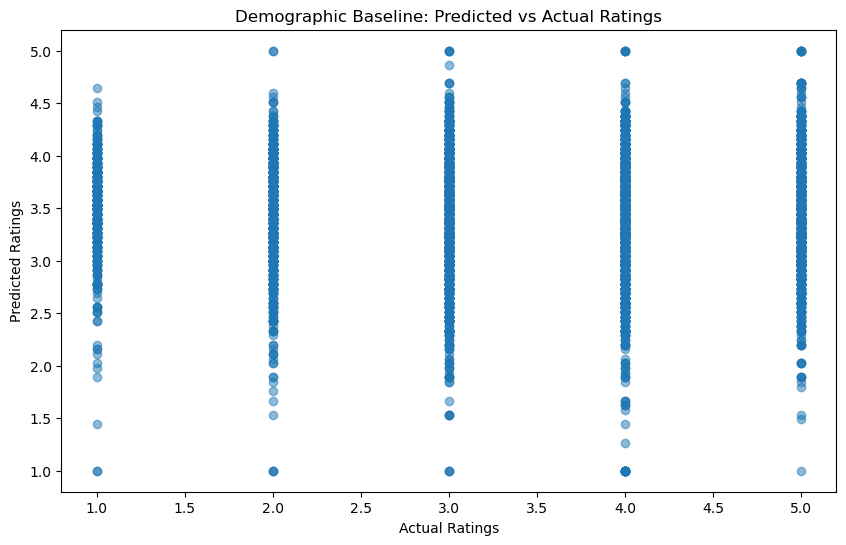

In [180]:
val_rmse, val_preds, val_actuals = baseline_model(val_ratings, merged_with_ratings)
test_rmse, test_preds, test_actuals = baseline_model(test_ratings, merged_with_ratings)

print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(test_actuals, test_preds, alpha=0.5)
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Demographic Baseline: Predicted vs Actual Ratings')
plt.show()

In [181]:
#General prediction eval function

def evaluate_predictions(actuals, predictions):
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)
    bias = np.mean(np.array(predictions) - np.array(actuals))
    
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R2 Score: {r2:.4f}")
    print(f"Bias: {bias:.4f}")

In [182]:
evaluate_predictions(test_actuals, test_preds)

RMSE: 1.2512
MAE: 1.0152
R2 Score: -0.2382
Bias: -0.0826


So this is still pretty widespread, to get a better baseline incorporate information we might have about a given user, say his/her past rating genre biases


Genre-Bias Baseline Results:
Coverage: 90.44%
RMSE: 1.1672
MAE: 0.9337
R2 Score: -0.0912
Bias: -0.0754


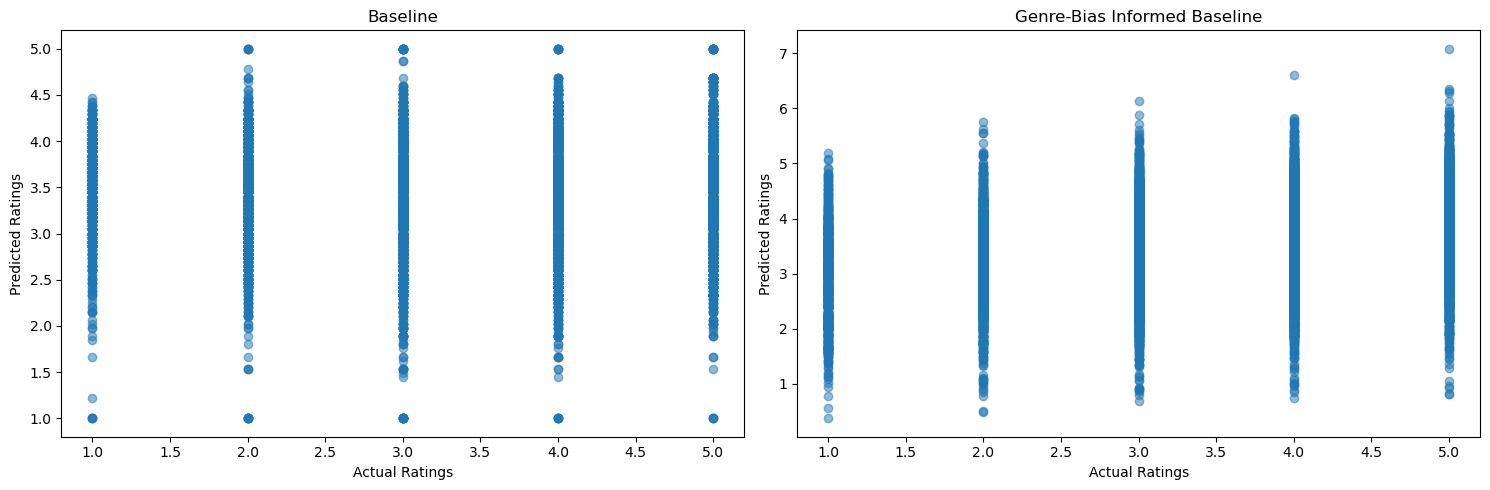

In [183]:
genres = ["Action", 
    "Adventure", 
    "Animation", 
    "Children's", 
    "Comedy", 
    "Crime", 
    "Documentary", 
    "Drama", 
    "Fantasy", 
    "Film-Noir", 
    "Horror", 
    "Musical", 
    "Mystery", 
    "Romance", 
    "Sci-Fi", 
    "Thriller", 
    "War", 
    "Western"]

def find_user_genre_biases(train_data, movies_data):
    user_genre_biases = {}
    global_mean = train_data['rating'].mean()
    
    for genre in genres:
        #Find movies in genre
        genre_mask = movies_data[genre] == 1
        genre_movies = movies_data[genre_mask]['id']
        
        #If possible generate user genre-bias
        genre_ratings = train_data[train_data['movieId'].isin(genre_movies)]
        user_biases = {}
        
        for user_id in genre_ratings['userId'].unique():
            user_genre_ratings = genre_ratings[genre_ratings['userId'] == user_id]
            if len(user_genre_ratings) > 0:  #if user did rate in this genre
                user_mean = user_genre_ratings['rating'].mean()
                user_biases[user_id] = user_mean / global_mean
            
        user_genre_biases[genre] = user_biases
    
    return user_genre_biases

def predict_demographic_rating_with_genre_bias(row, movies_data, user_genre_biases):
    movie = movies_data[movies_data['id'] == row['movieId']]
    if len(movie) == 0:
        return np.nan
    
    # previous mthd of gender, age_group
    demo_col = get_demographic(row['gender'], row['age_group'])
    base_pred = None
    
    if not pd.isna(movie[demo_col].iloc[0]):
        base_pred = movie[demo_col].iloc[0]
    else:
        #Fallback to just age group
        age_col = f"{row['age_group']}_avg"
        if age_col in movie.columns and not pd.isna(movie[age_col].iloc[0]):
            base_pred = movie[age_col].iloc[0]
        else:
            #Just gender
            gender_col = f"{row['gender']}_avg"
            if gender_col in movie.columns and not pd.isna(movie[gender_col].iloc[0]):
                base_pred = movie[gender_col].iloc[0]
    
    if base_pred is None:
        return np.nan
        
    #Apply users' genre bias
    genre_scaling = 1.0
    genre_count = 0
    
    for genre in genres:
        if movie[genre].iloc[0] == 1:  #If movie in genre
            if (genre in user_genre_biases and 
                row['userId'] in user_genre_biases[genre]):
                genre_scaling *= user_genre_biases[genre][row['userId']]
                genre_count += 1
    
    if genre_count > 0:
        #Take mean over genres
        genre_scaling = genre_scaling ** (1/genre_count)
        return base_pred * genre_scaling
    
    return base_pred

def bias_baseline_model(train_df, test_df, movie_demographics):
    user_genre_biases = find_user_genre_biases(train_df, movie_demographics)
    
    predictions = []
    actuals = []
    missing = 0
    
    for _, row in test_df.iterrows():
        pred = predict_demographic_rating_with_genre_bias(row, movie_demographics, user_genre_biases)
        if not np.isnan(pred):
            predictions.append(pred)
            actuals.append(row['rating'])
        else:
            missing += 1
    
    coverage = 1 - (missing / len(test_df))
    print(f"Coverage: {coverage:.2%}")
    evaluate_predictions(actuals, predictions)
    return predictions, actuals

print("\nGenre-Bias Baseline Results:")
# Use info from train/val ratings
bias_val_preds, bias_val_actuals = bias_baseline_model(
    train_ratings, 
    val_ratings, 
    merged_with_ratings
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.scatter(val_actuals, val_preds, alpha=0.5)
ax1.set_xlabel('Actual Ratings')
ax1.set_ylabel('Predicted Ratings')
ax1.set_title('Baseline')

ax2.scatter(bias_val_actuals, bias_val_preds, alpha=0.5)
ax2.set_xlabel('Actual Ratings')
ax2.set_ylabel('Predicted Ratings')
ax2.set_title('Genre-Bias Informed Baseline')

plt.tight_layout()
plt.show()

So we definitely have improved slightly. Notice in the graph of actual vs predicted ranges, the distributions while still widespread approximate a linear regression fitting line. We also improved on our metrics.

In [184]:
train_ratings

,userId,movieId,rating,timestamp,age,gender,zipcode,state,age_group
52511,655,1532,2,887476999,50,F,60657,IL,45
36485,499,258,2,885598932,42,M,75006,TX,30
48982,629,423,5,880117333,46,F,44224,OH,45
31737,456,405,1,881371942,24,M,31820,GA,18
16731,296,663,5,884198772,43,F,16803,PA,30
...,...,...,...,...,...,...,...,...,...
6265,109,53,4,880583336,29,M,55423,MN,18
54886,682,282,4,888519918,23,M,55128,MN,18
76820,910,282,3,880821319,28,M,29301,SC,18
860,11,727,3,891904335,39,F,30329,GA,30


## Data Exploration

In [185]:
merged_with_ratings.columns

Index(['id', 'title', 'unknown', 'Action', 'Adventure', 'Animation',
       'Children's', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
       'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
       'Thriller', 'War', 'Western', 'mod_year', 'release_year', 'imdbId',
       'tmdbId', 'budget', 'genres', 'data_id', 'imdb_id', 'original_language',
       'overview', 'popularity', 'production_companies',
       'production_countries', 'revenue', 'runtime', 'spoken_languages',
       'tagline', '_avg', '_votes', 'weighted_avg', 'total_votes', 'mean_vote',
       'median_vote', 'votes_5', 'votes_4', 'votes_3', 'votes_2', 'votes_1',
       '0_avg', '0_votes', '18_avg', '18_votes', '30_avg', '30_votes',
       '45_avg', '45_votes', 'M_avg', 'M_votes', 'M0_avg', 'M0_votes',
       'M18_avg', 'M18_votes', 'M30_avg', 'M30_votes', 'M45_avg', 'M45_votes',
       'F_avg', 'F_votes', 'F0_avg', 'F0_votes', 'F18_avg', 'F18_votes',
       'F30_avg', 'F30_votes', 'F45_avg', 'F45_

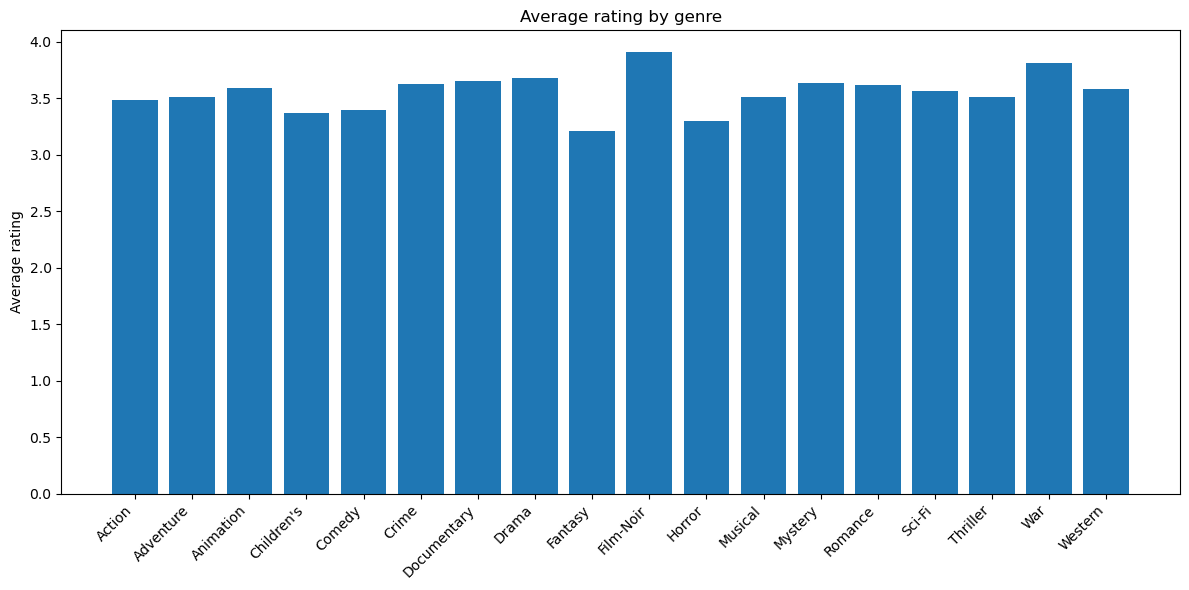

In [186]:
#View ratings by genre
genre_ratings = {}
for genre in genres:
    genre_mask = movies_lens_items[genre] == 1
    genre_data = ratings_with_demographics[ratings_with_demographics['movieId'].isin(movies_lens_items[genre_mask]['id'])]
    genre_ratings[genre] = genre_data['rating'].mean()

plt.figure(figsize=(12, 6))
plt.bar(genre_ratings.keys(), genre_ratings.values())
plt.xticks(rotation=45, ha='right')
plt.title('Average rating by genre')
plt.ylabel('Average rating')
plt.tight_layout()
plt.show()

No definitively better genres, though fantasy and horror tend to rate lower, and noir and war higher.

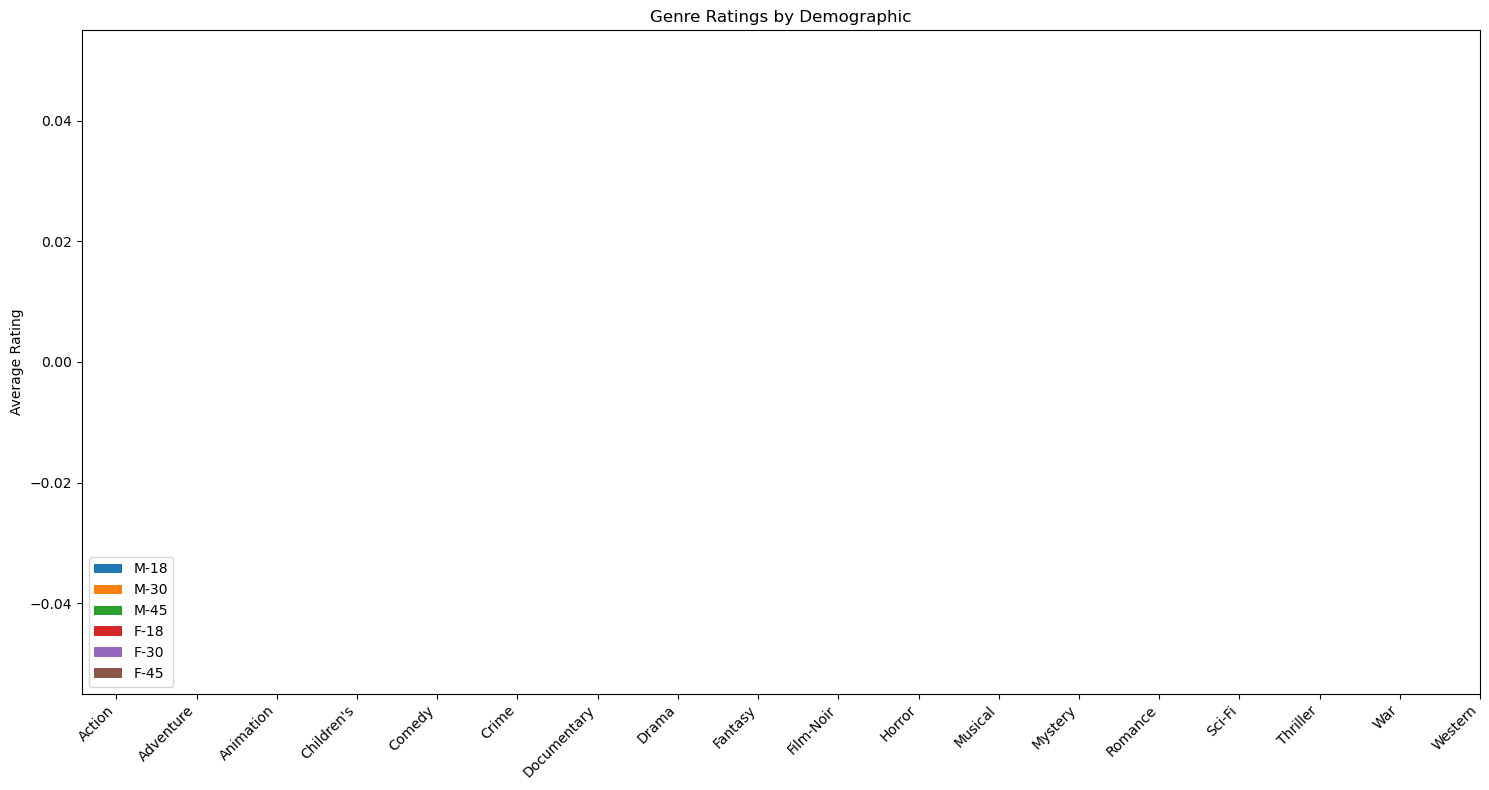

In [187]:
# By genre by demograpihc
def plot_genre_demographic_ratings(data, genres):
    fig, ax = plt.subplots(figsize=(15, 8))
    x = np.arange(len(genres))
    width = 0.15
    
    demographics = [('M', '18'), ('M', '30'), ('M', '45'), ('F', '18'), ('F', '30'), ('F', '45')]
    for i, (gender, age) in enumerate(demographics):
        means = []
        for genre in genres:
            genre_mask = data[genre] == 1
            demo_mask = (ratings_with_demographics['gender'] == gender) & \
                       (ratings_with_demographics['age_group'] == age)
            genre_demo_ratings = ratings_with_demographics[demo_mask & \
                ratings_with_demographics['movieId'].isin(data[genre_mask]['id'])]
            means.append(genre_demo_ratings['rating'].mean())
        
        ax.bar(x + i*width, means, width, label=f'{gender}-{age}')
    
    ax.set_xticks(x + width * 2.5)
    ax.set_xticklabels(genres, rotation=45, ha='right')
    ax.set_ylabel('Average Rating')
    ax.set_title('Genre Ratings by Demographic')
    ax.legend()
    plt.tight_layout()
    plt.show()

plot_genre_demographic_ratings(movies_lens_items, genres)

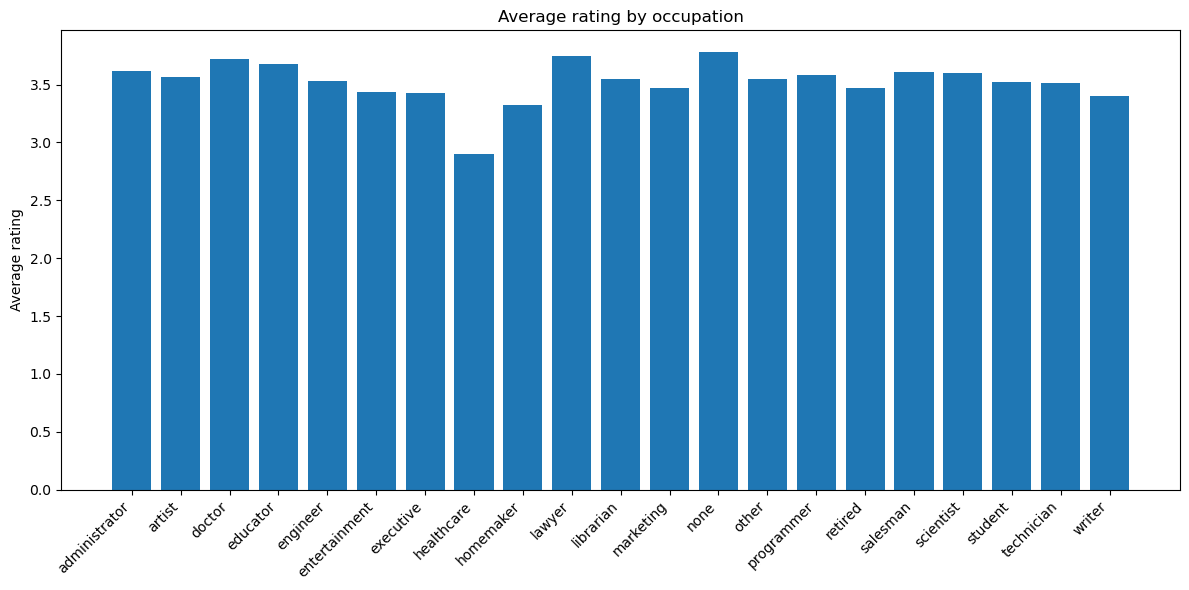

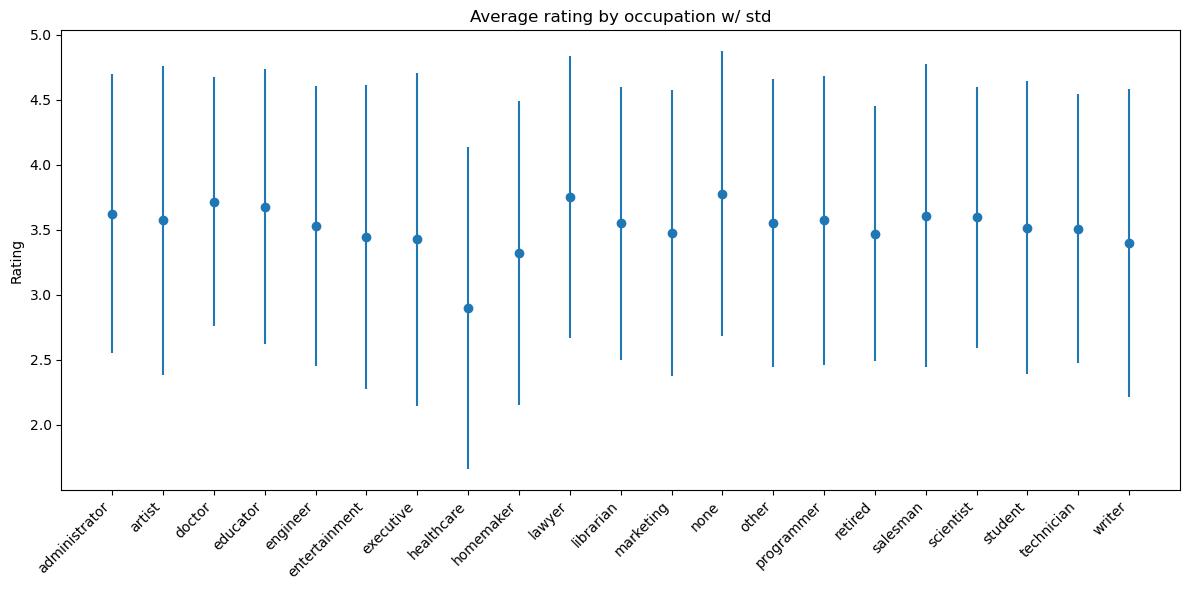

In [190]:
#By user occupation
occupation_ratings = ratings_with_demographics.merge(users[['userId', 'occupation']], on='userId')
occupation_means = occupation_ratings.groupby('occupation')['rating'].agg(['mean', 'count']).round(2)

plt.figure(figsize=(12, 6))
plt.bar(occupation_means.index, occupation_means['mean'])
plt.xticks(rotation=45, ha='right')
plt.title('Average rating by occupation')
plt.ylabel('Average rating')
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))
occupation_stats = occupation_ratings.groupby('occupation')['rating'].agg(['mean', 'std']).round(3)
plt.errorbar(occupation_stats.index, occupation_stats['mean'], 
            yerr=occupation_stats['std'], fmt='o')
plt.xticks(rotation=45, ha='right')
plt.title('Average rating by occupation w/ std')
plt.ylabel('Rating')
plt.tight_layout()
plt.show()

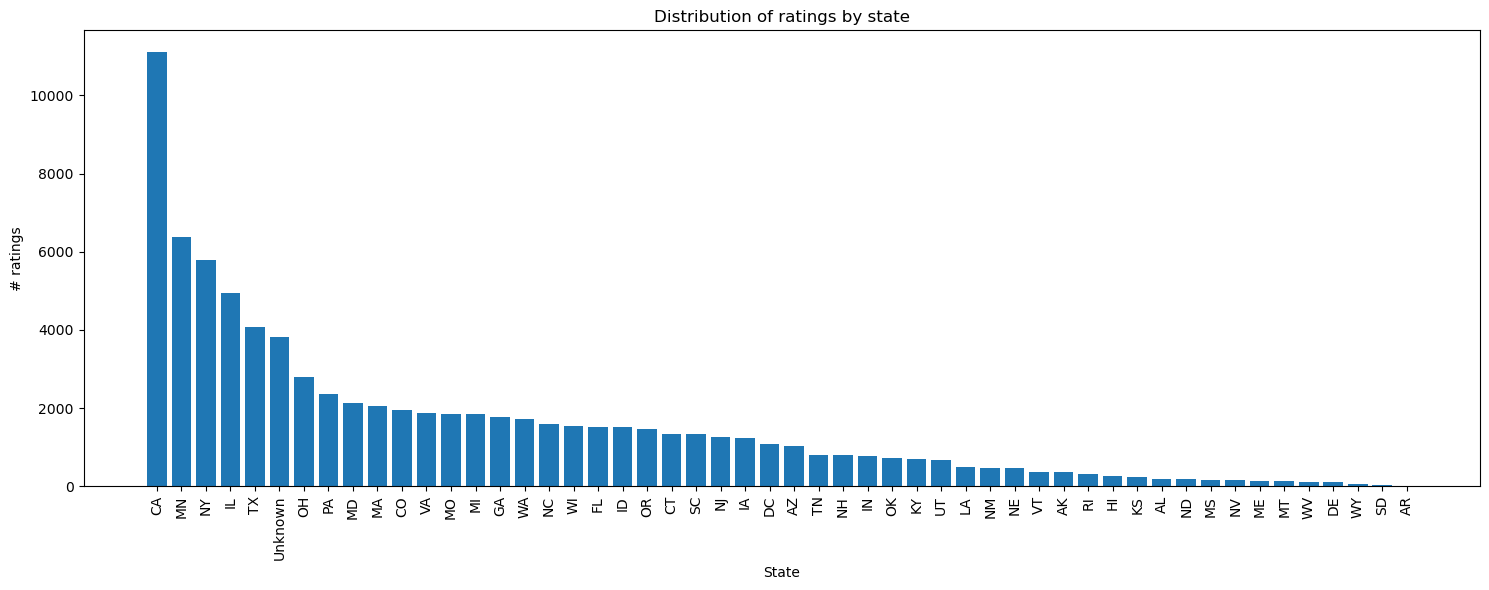


Average ratings by state:
          mean  count    std
state                       
WV       4.586    116  0.781
SD       4.308     39  0.731
ME       4.171    123  0.807
MT       4.090    122  1.044
KS       4.004    247  0.926
AL       3.929    196  1.079
MS       3.906    159  0.966
NH       3.775    787  1.033
WI       3.768   1529  1.097
MA       3.753   2041  1.036
IA       3.733   1240  1.048
NM       3.722    472  1.245
TN       3.720    790  1.090
FL       3.701   1520  1.106
NE       3.689    456  0.994
IN       3.682    771  1.059
UT       3.662    669  1.102
CT       3.654   1344  1.028
MO       3.650   1859  0.987
WA       3.649   1712  1.087
NC       3.620   1594  1.259
VT       3.611    373  1.006
PA       3.584   2358  1.107
CA       3.582  11110  1.083
LA       3.566    486  1.121
GA       3.564   1761  1.056
NV       3.545    156  1.204
OH       3.540   2798  1.107
DC       3.509   1085  1.119
WY       3.500     48  1.185
OK       3.499    723  1.062
MI       3.479  

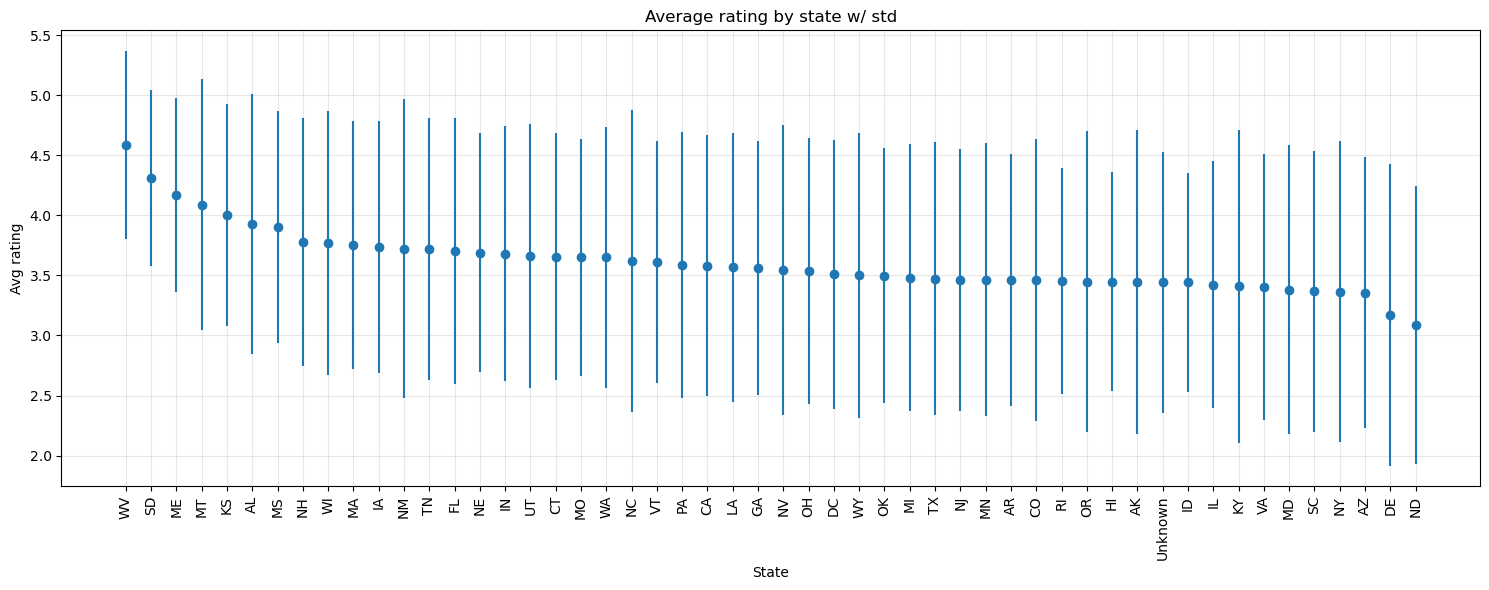

In [191]:
#Use state info to visulize
plt.figure(figsize=(15, 6))
state_counts = ratings_with_demographics['state'].value_counts()
plt.bar(state_counts.index, state_counts.values)
plt.xticks(rotation=90)
plt.title('Distribution of ratings by state')
plt.xlabel('State')
plt.ylabel('# ratings')
plt.tight_layout()
plt.show()

# Show avg rating by state
state_ratings = ratings_with_demographics.groupby('state')['rating'].agg(['mean', 'count', 'std']).round(3)
state_ratings = state_ratings.sort_values('mean', ascending=False)

print("\nAverage ratings by state:")
print(state_ratings)

plt.figure(figsize=(15, 6))
plt.errorbar(state_ratings.index, state_ratings['mean'], 
            yerr=state_ratings['std'], fmt='o')
plt.xticks(rotation=90)
plt.title('Average rating by state w/ std')
plt.xlabel('State')
plt.ylabel('Avg rating')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

So for embedding users, definitely is importance in using state information! zipcode will be too overfit

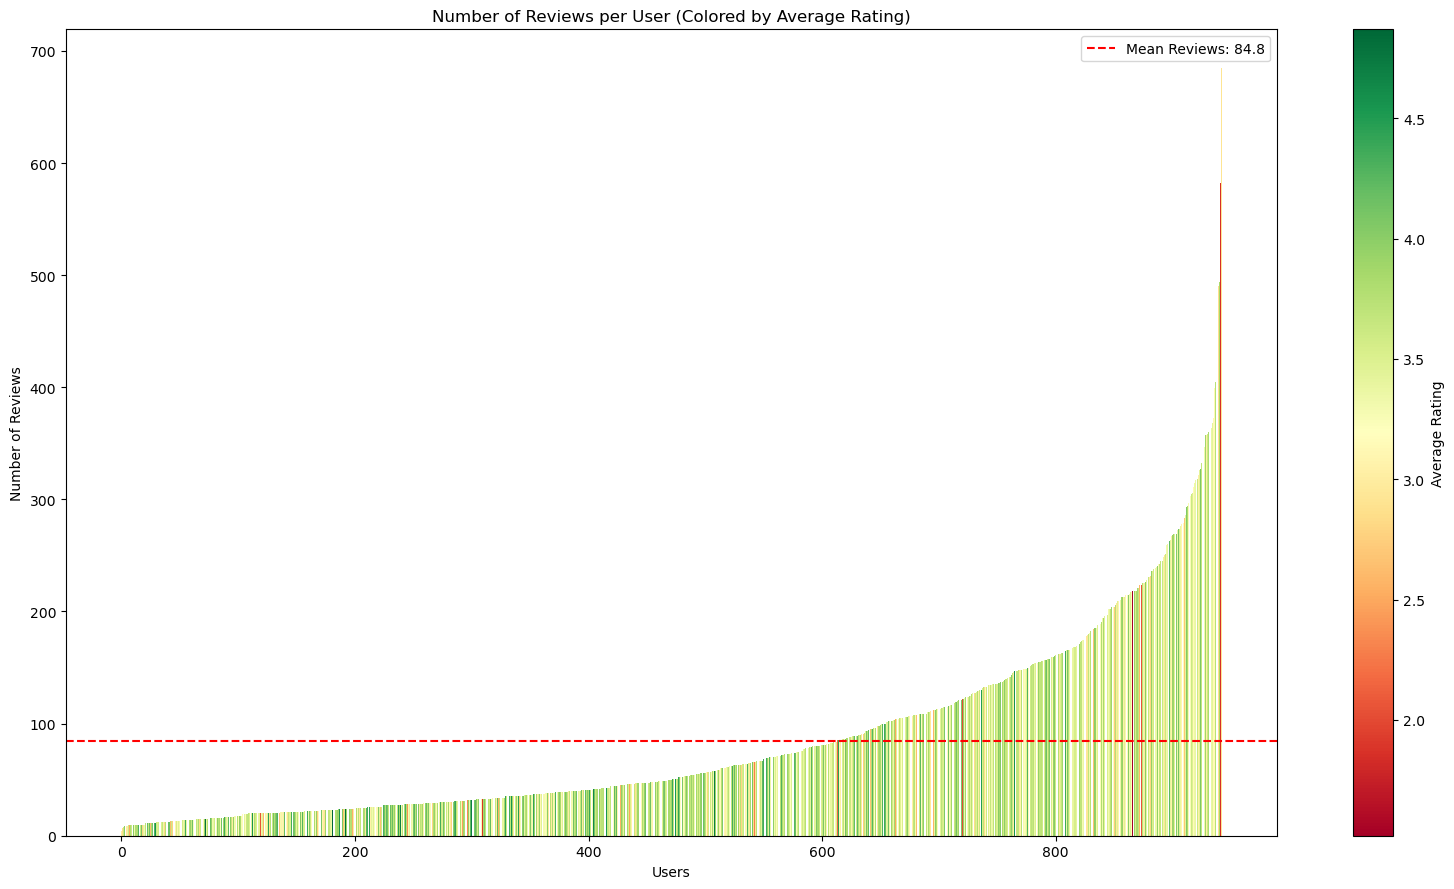

Avg # of reviews/user: 84.84
Correlation between # of reviews and avg rating: -0.136


In [192]:
#Visualize # of reviews per user and color based on rating - does more ratings~with higher/lower score?
user_stats = ratings_with_demographics.groupby('userId').agg({
    'rating': ['count', 'mean']
}).reset_index()
user_stats.columns = ['userId', 'num_reviews', 'avg_rating']

#sort by # review
user_stats = user_stats.sort_values('num_reviews', ascending=True)

min_rating = user_stats['avg_rating'].min()
max_rating = user_stats['avg_rating'].max()
norm = plt.Normalize(min_rating, max_rating)
cmap = plt.cm.RdYlGn

fig, ax = plt.subplots(figsize=(16, 9))
bars = ax.bar(range(len(user_stats)), user_stats['num_reviews'], 
             color=cmap(norm(user_stats['avg_rating'])))

#view average number reviews
mean_reviews = user_stats['num_reviews'].mean()
plt.axhline(y=mean_reviews, color='red', linestyle='--', label=f'Mean Reviews: {mean_reviews:.1f}')

plt.title('Number of Reviews per User (Colored by Average Rating)')
plt.xlabel('Users')
plt.ylabel('Number of Reviews')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Average Rating')

plt.legend()
plt.tight_layout()
plt.show()

print(f"Avg # of reviews/user: {mean_reviews:.2f}")
print(f"Correlation between # of reviews and avg rating: {user_stats['num_reviews'].corr(user_stats['avg_rating']):.3f}")

There is a slight negative correlation between number of review and average given rating. Also clear outliers which we can ignore when we embed users by specifying math path length.

In [194]:
keywords_df = pd.read_csv("movie-data/keywords.csv")

merged_with_keywords = pd.merge(
    merged_with_ratings,
    keywords_df,
    left_on="data_id",
    right_on="id",
    how="left"
)

In [195]:
#extract keyword 'tuples' from json
def parse_str(string):
    try:
        return ast.literal_eval(string)
    except:
        return []

merged_with_keywords['keywords'] = merged_with_keywords["keywords"].apply(parse_str)
merged_with_keywords['production_companies'] = merged_with_keywords['production_companies'].apply(parse_str)
merged_with_keywords['production_countries'] = merged_with_keywords["production_countries"].apply(parse_str)

#extract list of keywords
merged_with_keywords["keywords"] = merged_with_keywords['keywords'].apply(
    lambda x: [kw["name"] for kw in x] if x else []
)
merged_with_keywords['production_companies'] = merged_with_keywords['production_companies'].apply(
    lambda x: [kw["name"] for kw in x] if x else []
)
merged_with_keywords['production_countries'] = merged_with_keywords['production_countries'].apply(
    lambda x: [kw["name"] for kw in x] if x else []
)

In [196]:
merged_with_keywords = merged_with_keywords.drop(columns=['genres', 'original_language', 'spoken_languages'])
merged_with_keywords.columns

Index(['id_x', 'title', 'unknown', 'Action', 'Adventure', 'Animation',
       'Children's', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
       'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
       'Thriller', 'War', 'Western', 'mod_year', 'release_year', 'imdbId',
       'tmdbId', 'budget', 'data_id', 'imdb_id', 'overview', 'popularity',
       'production_companies', 'production_countries', 'revenue', 'runtime',
       'tagline', '_avg', '_votes', 'weighted_avg', 'total_votes', 'mean_vote',
       'median_vote', 'votes_5', 'votes_4', 'votes_3', 'votes_2', 'votes_1',
       '0_avg', '0_votes', '18_avg', '18_votes', '30_avg', '30_votes',
       '45_avg', '45_votes', 'M_avg', 'M_votes', 'M0_avg', 'M0_votes',
       'M18_avg', 'M18_votes', 'M30_avg', 'M30_votes', 'M45_avg', 'M45_votes',
       'F_avg', 'F_votes', 'F0_avg', 'F0_votes', 'F18_avg', 'F18_votes',
       'F30_avg', 'F30_votes', 'F45_avg', 'F45_votes', 'top1000_voters_rating',
       'top1000_voters_

In [197]:
merged_with_keywords[['budget', 'data_id', 'imdb_id',
       'overview', 'popularity', 'production_companies',
       'production_countries', 'revenue', 'runtime',
       'tagline']].head()

,budget,data_id,imdb_id,overview,popularity,production_companies,production_countries,revenue,runtime,tagline
0,30000000.0,862.0,114709,"Led by Woody, Andy's toys live happily in his ...",21.946943,[Pixar Animation Studios],[United States of America],373554033.0,81.0,NaN
1,58000000.0,710.0,113189,James Bond must unmask the mysterious head of ...,14.686036,"[United Artists, Eon Productions]","[United Kingdom, United States of America]",352194034.0,130.0,No limits. No fears. No substitutes.
2,4000000.0,5.0,113101,It's Ted the Bellhop's first night on the job....,9.026586,"[Miramax Films, A Band Apart]",[United States of America],4300000.0,98.0,Twelve outrageous guests. Four scandalous requ...
3,30250000.0,8012.0,113161,Chili Palmer is a Miami mobster who gets sent ...,12.669608,"[Jersey Films, Metro-Goldwyn-Mayer (MGM)]",[United States of America],115101622.0,105.0,"The mob is tough, but itâs nothing like show..."
4,0.0,1710.0,112722,An agoraphobic psychologist and a female detec...,10.701801,"[Regency Enterprises, New Regency Pictures]",[United States of America],0.0,124.0,One man is copying the most notorious killers ...


# Collaborative Filtering Model
Since we have so much non-linear information about connection between movies, users, and between both groups we will create latent embeddings for both and then use a NN to match across for a collaboritve filter type system.

In [198]:
#First embed movie attributes

movie_unembedded = merged_with_keywords.copy()

#handle numerix columns
"""numerics = ['revenue', 'runtime', 'budget', 'popularity'
       'vote_average', 'vote_count', 'weighted_average_vote',
       'total_votes', 'mean_vote', 'median_vote', 'votes_5', 'votes_4',
       'votes_3', 'votes_2', 'votes_1', '0_avg', '0_votes', '18_avg',
       '18_votes', '30_avg', '30_votes', '45_avg', '45_votes', 'M_avg',
       'M_votes', 'M0_avg', 'M0_votes', 'M18_avg', 'M18_votes', 'M30_avg',
       'M30_votes', 'M45_avg', 'M45_votes', 'F_avg', 'F_votes', 'F0_avg',
       'F0_votes', 'F18_avg', 'F18_votes', 'F30_avg', 'F30_votes', 'F45_avg',
       'F45_votes', 'top1000_voters_rating', 'top1000_voters_votes',
       'us_voters_rating', 'us_voters_votes', 'non_us_voters_rating',
       'non_us_voters_votes']"""

#normalize/scale pure numerics:
movie_unembedded['revenue_norm'] = np.log1p(movie_unembedded['revenue'])
movie_unembedded['budget_norm'] = np.log1p(movie_unembedded['budget'])
movie_unembedded['popularity_norm'] = np.log1p(movie_unembedded['popularity'])

scaler = StandardScaler()
movie_unembedded[['revenue_norm', 'runtime', 'budget_norm', 'popularity_norm']] = scaler.fit_transform(
    movie_unembedded[['revenue_norm', 'runtime', 'budget_norm', 'popularity_norm']]
)

#vote rating columns can be kept as is

#to not overbias movies with more reviews, normalize votes for each category by # votes given in category, that is how confideent are we in given ratings?
mean = movie_unembedded["weighted_avg"].mean()
m=100
avg_cols = [col for col in movie_unembedded.columns if col.endswith('_avg')]

for avg_col in avg_cols:
    #corresponding total vote column
    votes_col = avg_col.replace('_avg', '_votes')
    
    if not votes_col in movie_unembedded.columns:
        continue

    normalized_col = avg_col.replace('_avg', '_norm')
    votes = movie_unembedded[votes_col]
    avgs = movie_unembedded[avg_col]
    movie_unembedded[normalized_col] = (votes / (votes + m)) * avgs + (mean / (votes + m)) * mean

#For year just normalize on bounds
movie_unembedded['release_year_norm'] = (movie_unembedded['release_year'] - movie_unembedded['release_year'].min()) / (movie_unembedded['release_year'].max() - movie_unembedded['release_year'].min())
movie_unembedded['keywords_text'] = movie_unembedded['keywords'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '').tolist()


In [199]:
movie_unembedded['keywords_text']

0       jealousy toy boy friendship friends rivalry bo...
1       cuba falsely accused secret identity computer ...
2       hotel new year's eve witch bet hotel room sper...
3       gambling miami based on novel job murder trave...
4       police brutality psychology police operation p...
                              ...                        
1679    fbi gang war surgeon beautiful woman los angel...
1680    paraplegic suicide attempt cheating dna spacem...
1681               prison new mexico smuggling gang theft
1682    based on novel mother daughter relationship ch...
1683    martial arts authority tournament battle fight...
Name: keywords_text, Length: 1684, dtype: object

In [200]:
#embed text per movie

word2vec = api.load("word2vec-google-news-300")#use word2vec for preembedded words

texts = movie_unembedded['overview'].fillna('').tolist() + movie_unembedded['tagline'].fillna('').tolist() + movie_unembedded['keywords_text'].fillna('').tolist()

#tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index

#sequence for tf
overview_seqs = tokenizer.texts_to_sequences(movie_unembedded['overview'].fillna(''))
tagline_seqs = tokenizer.texts_to_sequences(movie_unembedded['tagline'].fillna(''))
keywords_seqs = tokenizer.texts_to_sequences(movie_unembedded['keywords_text'].fillna(''))

#pad for lstm
max_len = 200
overview_padded = pad_sequences(overview_seqs, maxlen=max_len)
tagline_padded = pad_sequences(tagline_seqs, maxlen=max_len)
keywords_padded = pad_sequences(keywords_seqs, maxlen=max_len)

#embed
embedding_dim = 300
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

#find embedding in word2vec
for word, i in word_index.items():
    if word in word2vec:
        embedding_matrix[i] = word2vec[word]


embedding_layer = Embedding(
    input_dim=len(word_index) + 1,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=max_len,
    trainable=False
)
#create seperate LSTM embedding for each feature
overview_processor = Sequential([
    Input(shape=(max_len,)),
    embedding_layer,
    LSTM(128)
])

#tagline and keywords are shorter so we adjust LSTM accordingly
tagline_processor = Sequential([
    Input(shape=(max_len,)),
    embedding_layer,
    LSTM(64)
])

keywords_processor = Sequential([
    Input(shape=(max_len,)),
    embedding_layer,
    LSTM(64)
])

#Now take these embeddings to create overall textual features embedding
final_processor = Sequential([
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu')
])

overview_input = Input(shape=(max_len,))
tagline_input = Input(shape=(max_len,))
keywords_input = Input(shape=(max_len,))

overview_features = overview_processor(overview_input)
tagline_features = tagline_processor(tagline_input)
keywords_features = keywords_processor(keywords_input)

combined = Concatenate()([overview_features, tagline_features, keywords_features])
movie_embedding = final_processor(combined)

movie_text_embedder = Model(
    inputs=[overview_input, tagline_input, keywords_input],
    outputs=movie_embedding
)

embedding_output = movie_text_embedder([
    overview_padded,
    tagline_padded,
    keywords_padded
], training=False)

2025-05-20 23:21:17.843243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-05-20 23:21:17.883407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-05-20 23:21:17.886288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [201]:
embedding_output

<tf.Tensor: shape=(1684, 64), dtype=float32, numpy=
array([[0.020961  , 0.        , 0.00014299, ..., 0.        , 0.        ,
        0.01486516],
       [0.06613098, 0.        , 0.        , ..., 0.        , 0.        ,
        0.00211164],
       [0.01581104, 0.        , 0.        , ..., 0.0374238 , 0.        ,
        0.09312206],
       ...,
       [0.03026034, 0.        , 0.        , ..., 0.05915761, 0.        ,
        0.00764749],
       [0.        , 0.        , 0.00336457, ..., 0.03357458, 0.        ,
        0.0986982 ],
       [0.05222087, 0.        , 0.        , ..., 0.        , 0.        ,
        0.0965212 ]], dtype=float32)>

In [202]:
#now create overall movie embedding

embedding_dim=64

numeric_features = ['runtime', 'revenue_norm', 'budget_norm', 'popularity_norm', 'release_year_norm',
    '0_norm', '18_norm', '30_norm', '45_norm',
    'M_norm', 'M0_norm', 'M18_norm', 'M30_norm',
    'M45_norm', 'F_norm', 'F0_norm', 'F18_norm',
    'F30_norm', 'F45_norm', 'weighted_avg', 'total_votes'
]
#genres
movies_numeric = movie_unembedded[numeric_features].fillna(0).values.astype(np.float32)
movies_genres = movie_unembedded[genres].values.astype(np.float32)

text_input = Input(shape=(embedding_output.shape[1],))
numeric_input = Input(shape=(movies_numeric.shape[1],))
genre_input = Input(shape=(movies_genres.shape[1],))

numeric_dense = Dense(64, activation='relu')(numeric_input)
genre_dense = Dense(32, activation='relu')(genre_input)

combined_features = Concatenate()([text_input, numeric_dense, genre_dense])
final_dense = Sequential([
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(embedding_dim, activation='relu')
])

final_embedding = final_dense(combined_features)

movie_full_embedder = Model(
    inputs=[text_input, numeric_input, genre_input],
    outputs=final_embedding
)

embeddings = movie_full_embedder([
    embedding_output,
    movies_numeric,
    movies_genres
], training=False)

movie_items_embedded = {}
for movie_id, embedding in zip(movie_unembedded['id_x'], embeddings):
    movie_items_embedded[movie_id] = embedding.numpy()

To ensure we have a good embedding of movies, run PCA

/Users/daniellipshitz/miniconda3/envs/ml_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/daniellipshitz/miniconda3/envs/ml_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/var/folders/4q/fk1t6ktd7s5bmvx3nxqvsg300000gn/T/ipykernel_98530/4239591364.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_genres))


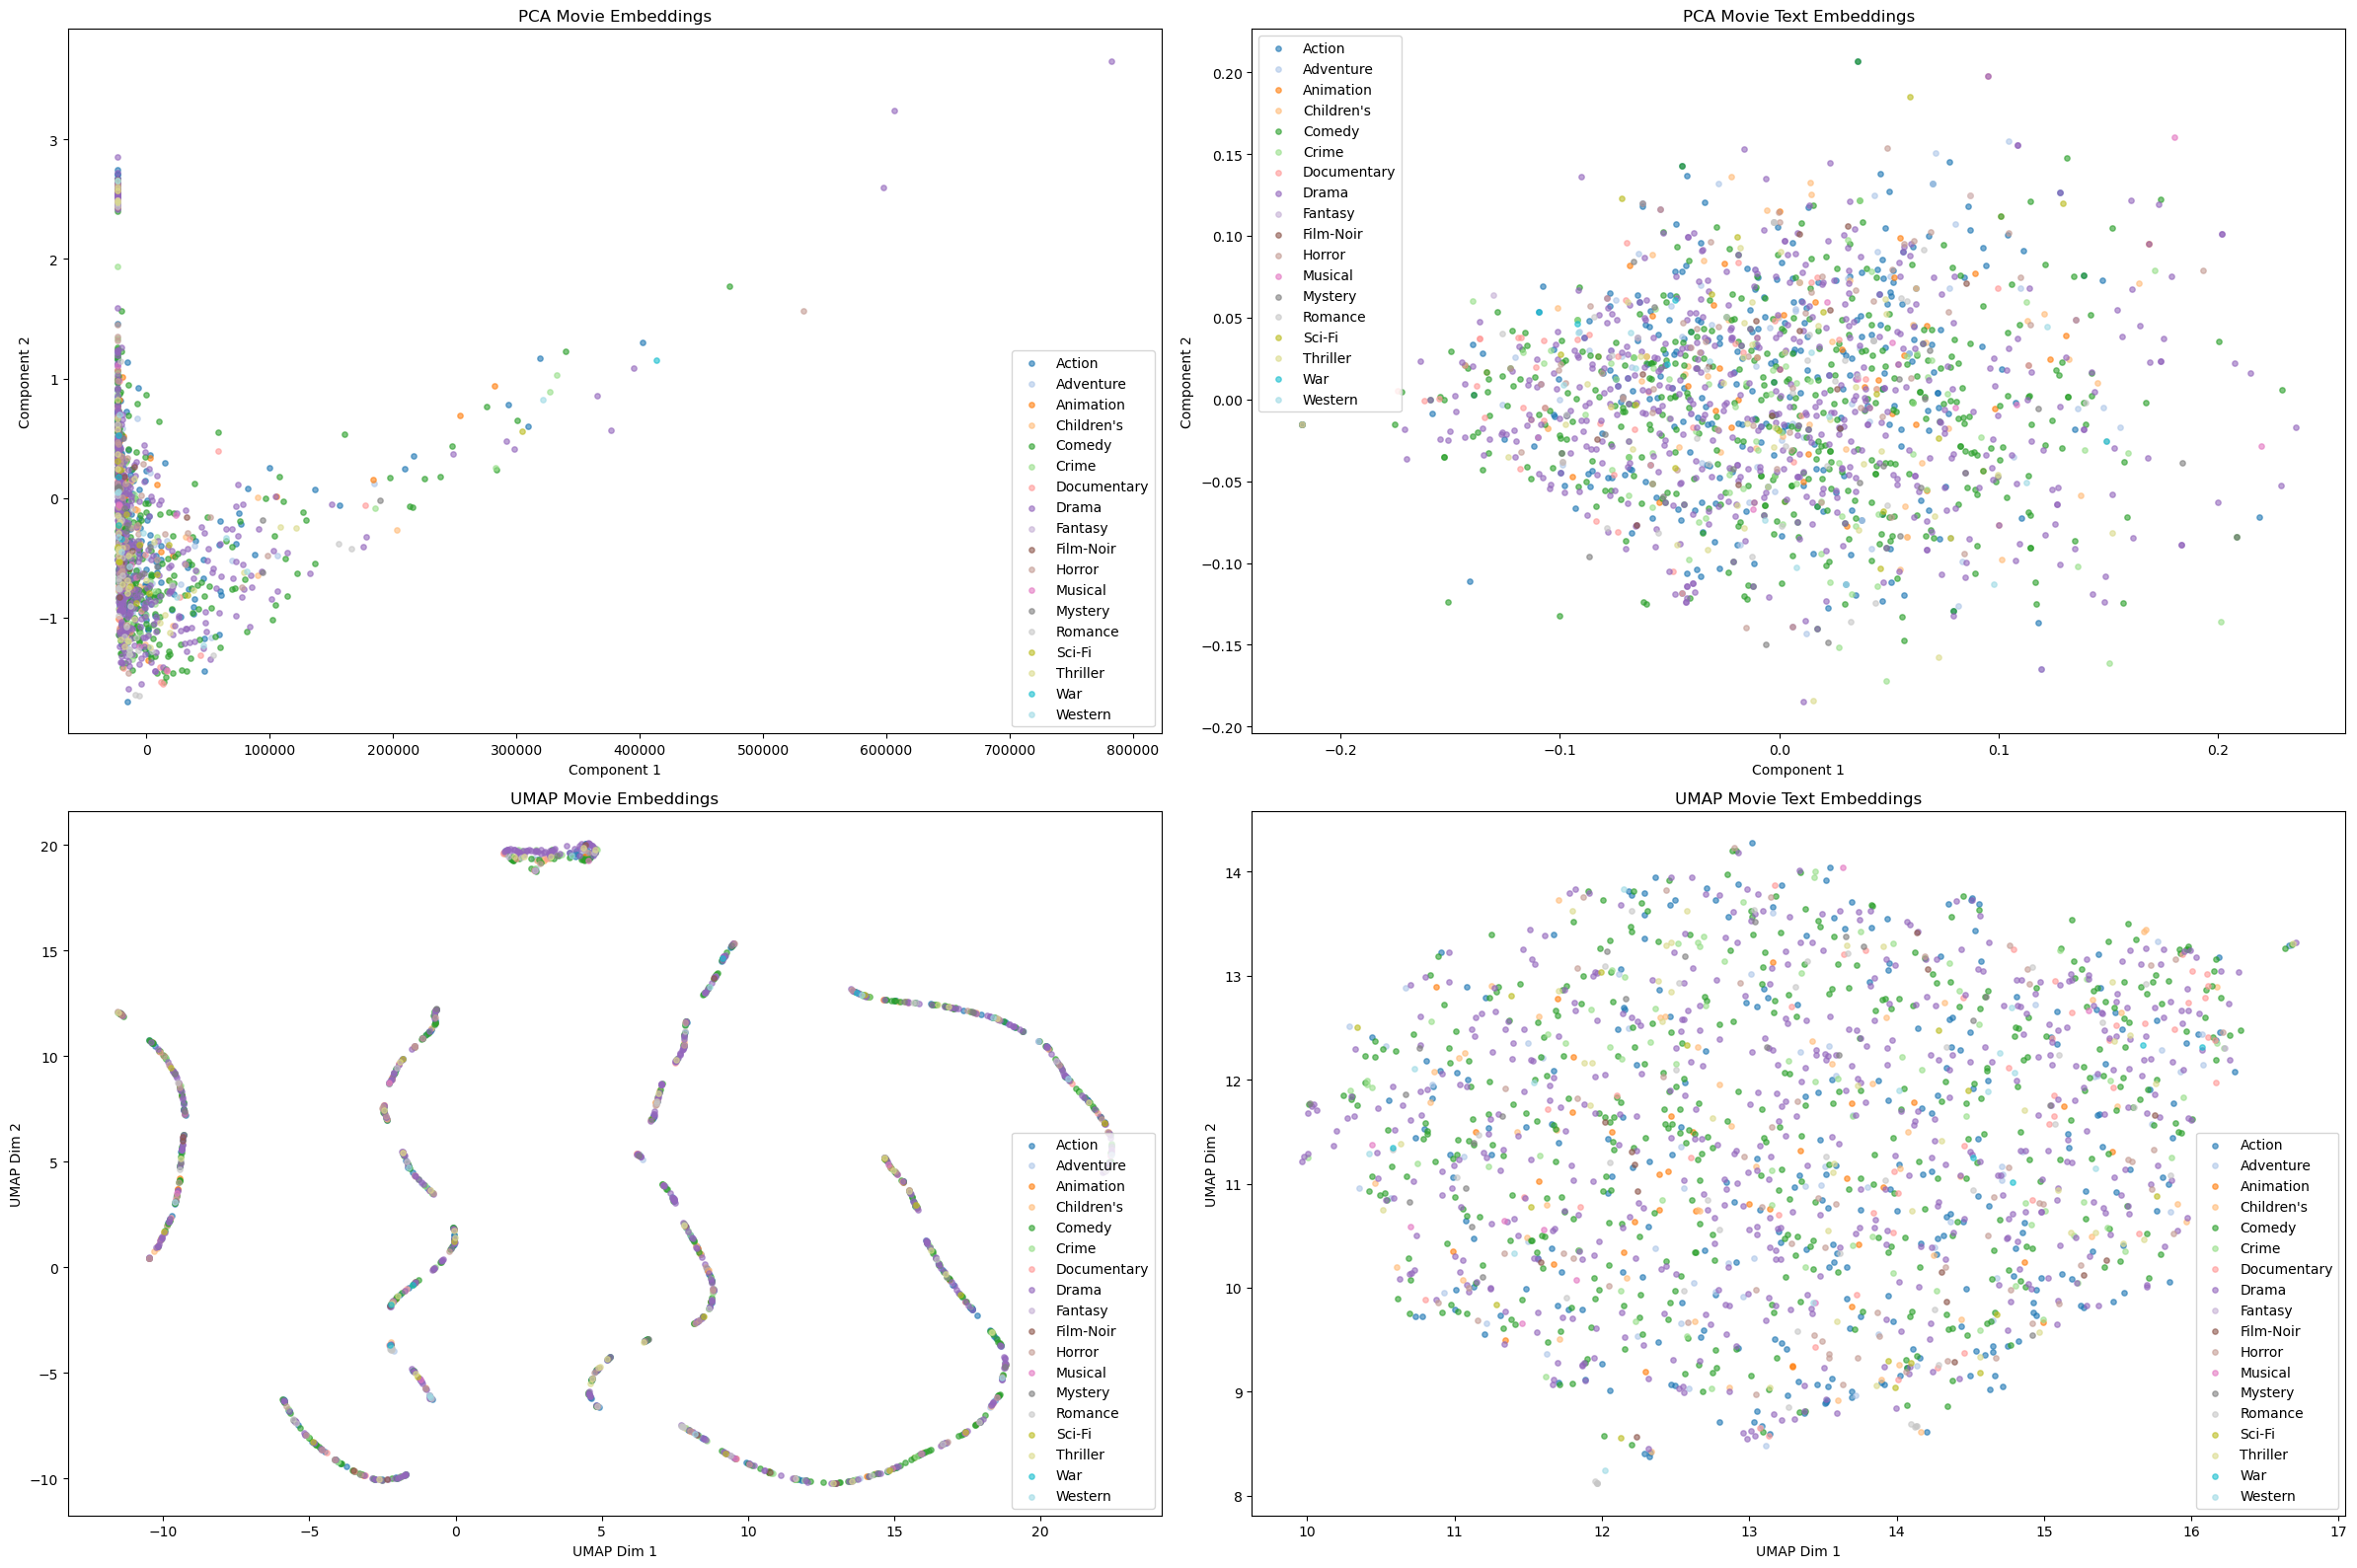

In [203]:
pca1 = PCA(n_components=2) #2d
movie_items_pca = pca1.fit_transform(embeddings)

pca2 = PCA(n_components=2)
movie_text_pca = pca2.fit_transform(embedding_output)

reducer1 = umap.UMAP(n_components=2, random_state=42)
movie_items_umap = reducer1.fit_transform(embeddings)

reducer2 = umap.UMAP(n_components=2, random_state=42)
movie_text_umap = reducer2.fit_transform(embedding_output)

genre_indices = np.argmax(movie_unembedded[genres].values, axis=1)
unique_genres = np.unique(genre_indices)
colors = plt.cm.get_cmap('tab20', len(unique_genres))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24, 16))

for i, genre_id in enumerate(unique_genres):
    idx = genre_indices == genre_id
    ax1.scatter(movie_items_pca[idx, 0], movie_items_pca[idx, 1], 
                color=colors(i), label=genres[genre_id], alpha=0.6, s=15)
    ax2.scatter(movie_text_pca[idx, 0], movie_text_pca[idx, 1], 
                color=colors(i), label=genres[genre_id], alpha=0.6, s=15)
    ax3.scatter(movie_items_umap[idx, 0], movie_items_umap[idx, 1],
                color=colors(i), label=genres[genre_id], alpha=0.6, s=15)
    ax4.scatter(movie_text_umap[idx, 0], movie_text_umap[idx, 1],
                color=colors(i), label=genres[genre_id], alpha=0.6, s=15)

ax1.legend()
ax1.set_title("PCA Movie Embeddings")
ax1.set_xlabel("Component 1")
ax1.set_ylabel("Component 2")

ax2.legend()
ax2.set_title("PCA Movie Text Embeddings")
ax2.set_xlabel("Component 1")
ax2.set_ylabel("Component 2")

ax3.legend()
ax3.set_title("UMAP Movie Embeddings")
ax3.set_xlabel("UMAP Dim 1")
ax3.set_ylabel("UMAP Dim 2")

ax4.legend()
ax4.set_title("UMAP Movie Text Embeddings")
ax4.set_xlabel("UMAP Dim 1")
ax4.set_ylabel("UMAP Dim 2")

plt.tight_layout()
plt.show()



Not sure what do make of this but text has a similar, yet random embedding in both. There does seem to be more of some rhyme/reason to movie embeddings.

### Embed User Ratings

In [204]:
ratings_with_demographics.columns

Index(['userId', 'movieId', 'rating', 'timestamp', 'age', 'gender', 'zipcode',
       'state', 'age_group', 'datetime', 'year'],
      dtype='object')

In [ ]:
def build_user_histories(train_df, movie_items_embedded, embedding_dim):
    user_histories = {}
    train_df_sorted = train_df.sort_values(['userId', 'timestamp'])

    for user_id, group in train_df_sorted.groupby('userId'):
        sequence = []
        for _, row in group.iterrows():
            movie_id = row['movieId']
            if movie_id in movie_items_embedded:
                emb = movie_items_embedded[movie_id]
                rating = row['rating']
                timestamp = row['timestamp']
                sequence.append(np.concatenate([emb, [rating], [timestamp]]))
        user_histories[user_id] = sequence
    return user_histories

def prepare_rnn_embedding(df, movie_items_embedded, embedding_dim,
                       scaler, categoricals, user_id_map, user_histories=None, max_seq_len=100):
    
    df = df.reset_index(drop=True)
    
    #Normalize age - for non-training it is needed
    df['age_scaled'] = scaler.transform(df[['age']])
    
    #One-hot encode categorical columns
    gender = pd.get_dummies(df['gender'], prefix='gender')
    gender = gender.reindex(columns=categoricals['gender'].columns, fill_value=0)#align with total info for each categorical
    gender.index = df.index

    state = pd.get_dummies(df['state'], prefix='state')
    state = state.reindex(columns=categoricals['state'].columns, fill_value=0)
    state.index = df.index

    age_group = pd.get_dummies(df['age_group'], prefix='age_group')
    age_group = age_group.reindex(columns=categoricals['age_group'].columns, fill_value=0)
    age_group.index = df.index

    """occupation = pd.get_dummies(df['occupation'], prefix='occupation')
    occupation = age_group.reindex(columns=categoricals['occupation'].columns, fill_value=0)
    occupation.index = df.index"""

    user_sequences, user_demo_features, user_ids, targets, movie_embs = [], [], [], [], []

    for idx, row in df.iterrows():
        user_id = row['userId']
        user_idx = user_id_map.get(user_id, 0)  # unseen users mapped to 0

        #Build rating histories during train/val only
        if user_histories is not None: #past user ratings passed in during testing
            hist = user_histories.get(user_id, [])
        else:
            hist_df = df[(df['userId'] == user_id) & (df.index < idx)]
            hist = []
            for _, h_row in hist_df.iterrows():
                m = h_row['movieId']
                if m in movie_items_embedded:
                    emb = movie_items_embedded[m]
                    r = h_row['rating']
                    t = h_row['timestamp']
                    hist.append(np.concatenate([emb, [r], [t]]))

        pad_len = max_seq_len - len(hist)
        if pad_len > 0:
            sequence = [[0.] * (embedding_dim + 2)] * pad_len + hist
        else:
            sequence = hist[-max_seq_len:]

        # Demographics
        demo = np.concatenate([
            [row['age_scaled']],
            gender.loc[row.name].values,
            state.loc[row.name].values,
            age_group.loc[row.name].values
        ])

        # Append to inputs
        user_sequences.append(sequence)
        user_demo_features.append(demo)
        user_ids.append(user_idx)
        targets.append(row['rating'])
        movie_embs.append(movie_items_embedded.get(row['movieId'], np.zeros(embedding_dim)))

    return {
        'user_id': np.array(user_ids),
        'user_seq': np.array(user_sequences),
        'user_demo': np.array(user_demo_features),
        'movie_emb': np.array(movie_embs),
        'targets': np.array(targets)
    }


In [207]:
max_seq_len=220
user_histories = build_user_histories(train_ratings, movie_items_embedded, embedding_dim)

In [ ]:
#Normalize age
age_scaler = StandardScaler()
age_scaler.fit(train_ratings[['age']])

#One-hot encode columns
gender_categorical_train = pd.get_dummies(train_ratings['gender'], prefix='gender')
state_categorical_train = pd.get_dummies(train_ratings['state'], prefix='state')
age_group_categorical_train = pd.get_dummies(train_ratings['age_group'], prefix='age_group')
#occupation_categorical_train = pd.get_dummies(train_ratings['occupation'], prefix='occupation')

categoricals = {
    'gender': gender_categorical_train,
    'state': state_categorical_train,
    'age_group': age_group_categorical_train#,
    #'occupation': occupation_categorical_train
}

num_users = train_ratings['userId'].nunique()
user_id_map = {uid: idx+1 for idx, uid in enumerate(train_ratings['userId'].unique())}

#To incorporate userId and timestamp we can need a way to incorporate how a given user has rated overtime
#=> we use a RNN to process ratings as sequential

#To deal with ratings for users with no or little past ratings (for cold start) we base on their demograhpic


train_data = prepare_rnn_embedding(
    train_ratings,
    movie_items_embedded,
    embedding_dim,
    age_scaler,
    categoricals,
    user_id_map,
    user_histories=None,
    max_seq_len=max_seq_len
)
print('training prepared')



training prepared


In [209]:
val_data = prepare_rnn_embedding(
    val_ratings,
    movie_items_embedded,
    embedding_dim,
    age_scaler,
    categoricals,
    user_id_map,
    user_histories=user_histories,
    max_seq_len=max_seq_len
)
print('validation prepared')

test_data = prepare_rnn_embedding(
    test_ratings,
    movie_items_embedded,
    embedding_dim,
    age_scaler,
    categoricals,
    user_id_map,
    user_histories=user_histories,
    max_seq_len=max_seq_len
)
print('testing prepared')

validation prepared
testing prepared


In [210]:
test_demo_data = prepare_rnn_embedding(
    test_ratings_with_demographics,
    movie_items_embedded,
    embedding_dim,
    age_scaler,
    categoricals,
    user_id_map,
    user_histories=user_histories,
    max_seq_len=max_seq_len
)
print('final testing prepared')

final testing prepared


In [ ]:
#embed user-ratings

demo_dim = (
    1 +  #age_scaled
    len(gender_categorical_train.columns) +
    len(state_categorical_train.columns) +
    len(age_group_categorical_train.columns)
)

user_id_input = Input(shape=(1,), name='user_id')
user_seq_input = Input(shape=(max_seq_len, embedding_dim + 2), name='rating_sequence')  # ratings, movie embedding + timestamp
user_demo_input = Input(shape=(demo_dim,), name='user_demo')  # demographic vector

#embeding for each userId as fallback for cold start
user_id_emb = Embedding(input_dim=num_users + 1, output_dim=embedding_dim, mask_zero=False)(user_id_input)
user_id_emb = Flatten()(user_id_emb)

# LSTM for rating history
user_seq_emb = LSTM(128)(user_seq_input)
user_seq_emb = Dense(embedding_dim, activation='relu')(user_seq_emb)

# Combine features: RNN ratings history + demographic + uID embedding
user_full_emb = Concatenate()([user_seq_emb, user_demo_input, user_id_emb])
user_final_emb = Dense(embedding_dim, activation='relu')(user_full_emb)

user_embedding_model = Model(
    inputs=[user_id_input, user_seq_input, user_demo_input],
    outputs=user_final_emb
)

#on training input
user_embeddings = user_embedding_model.predict([
    train_data['user_id'],
    train_data['user_seq'],
    train_data['user_demo']
])

2025-05-20 23:34:55.958257: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-05-20 23:34:55.962769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-05-20 23:34:55.966110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1476/1750 [========================>.....] - ETA: 32s

In [ ]:
user_embeddings.shape

(56000, 64)

/Users/daniellipshitz/miniconda3/envs/ml_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/var/folders/4q/fk1t6ktd7s5bmvx3nxqvsg300000gn/T/ipykernel_1127/2442658216.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10')(np.linspace(0, 1, len(unique_age_groups)))


IndexError: boolean index did not match indexed array along dimension 0; dimension is 56000 but corresponding boolean dimension is 1684

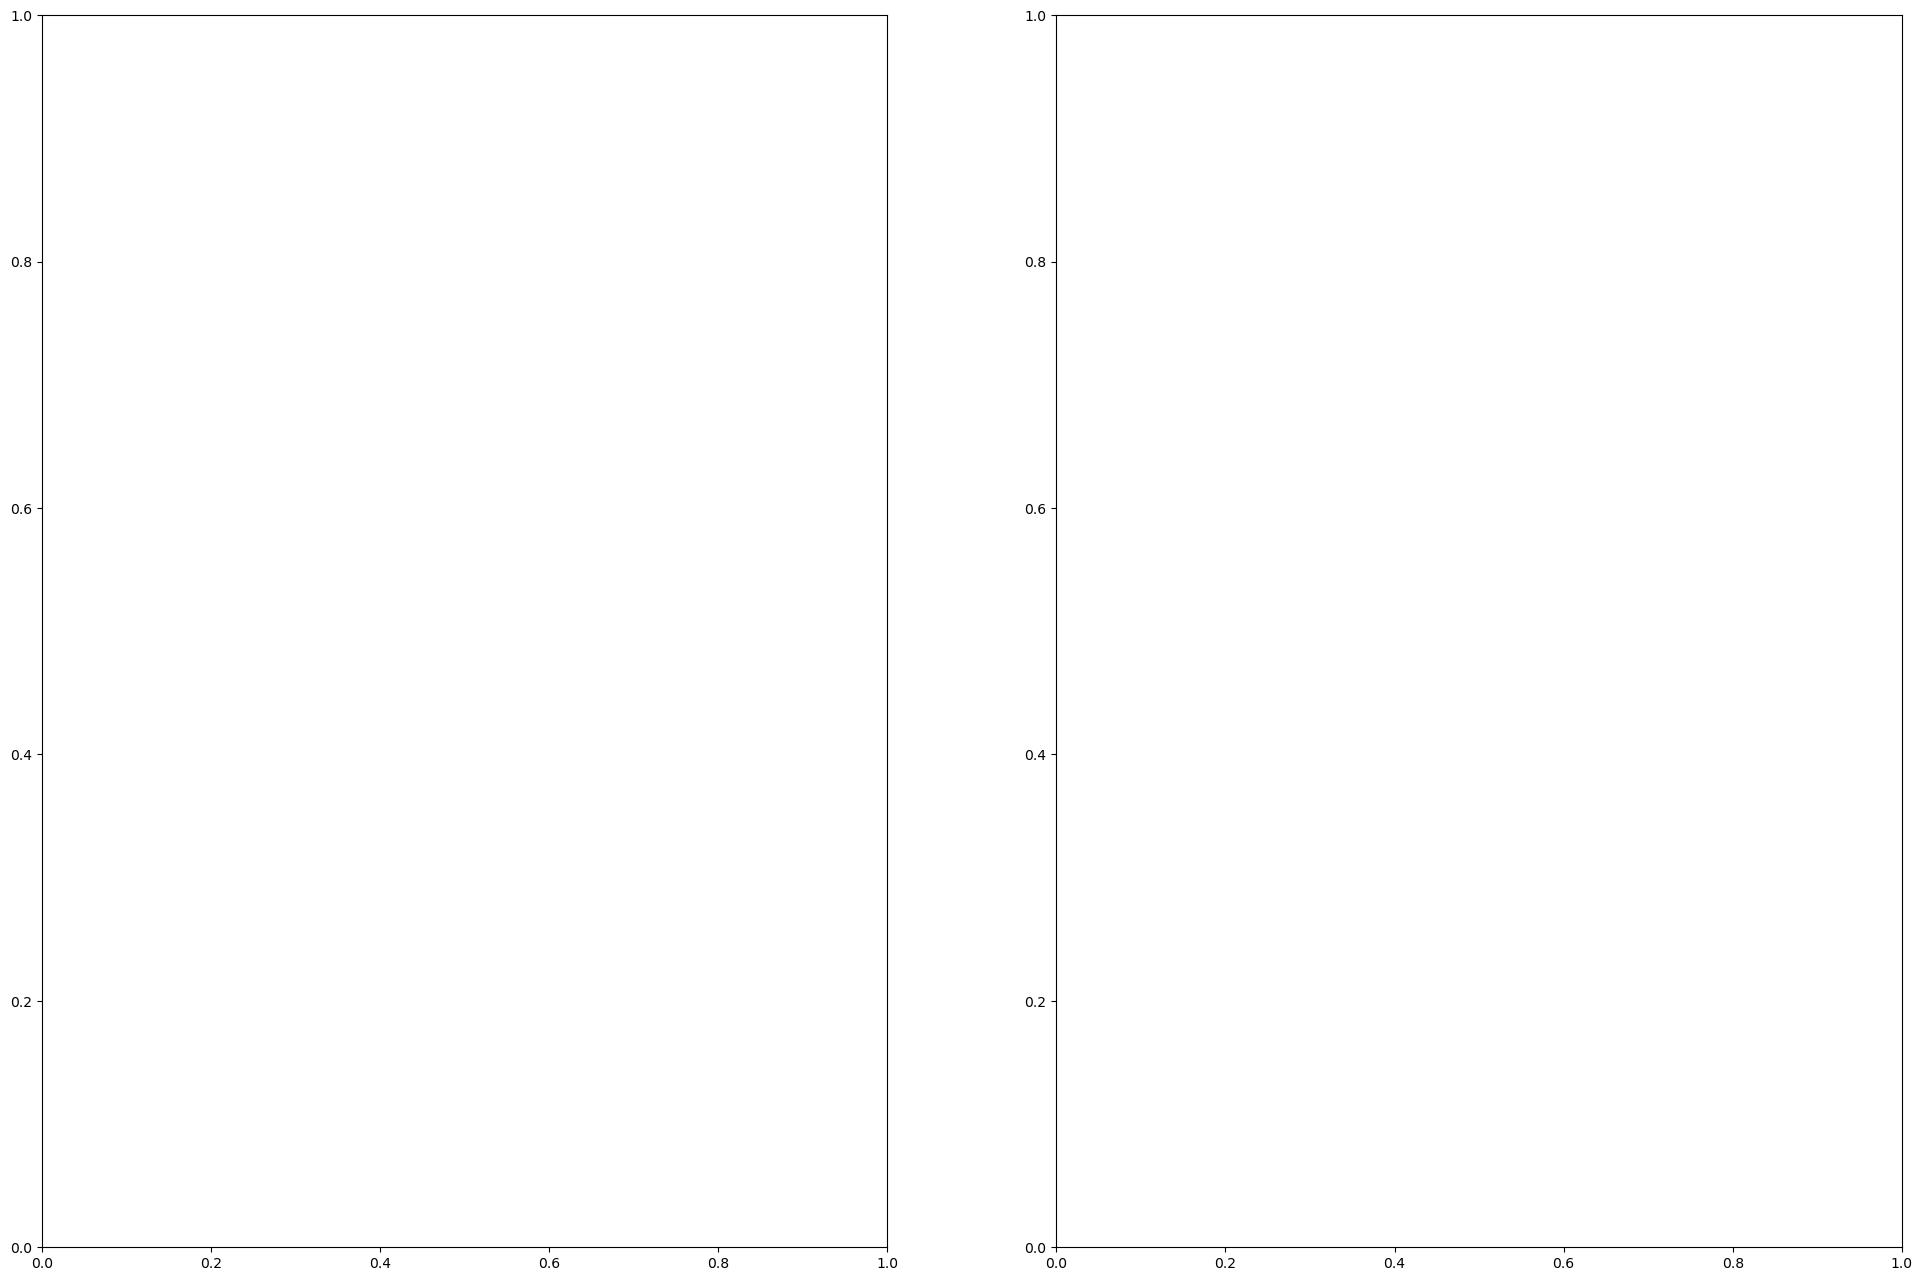

In [ ]:
u_pca = PCA(n_components=2) #2d
user_pca = u_pca.fit_transform(user_embeddings)


user_reducer = umap.UMAP(n_components=2, random_state=42)
user_umap = user_reducer.fit_transform(user_embeddings)





In [ ]:
user_pca.shape

(56000, 2)

/var/folders/4q/fk1t6ktd7s5bmvx3nxqvsg300000gn/T/ipykernel_1127/451671798.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10')(np.linspace(0, 1, len(unique_age_groups)))


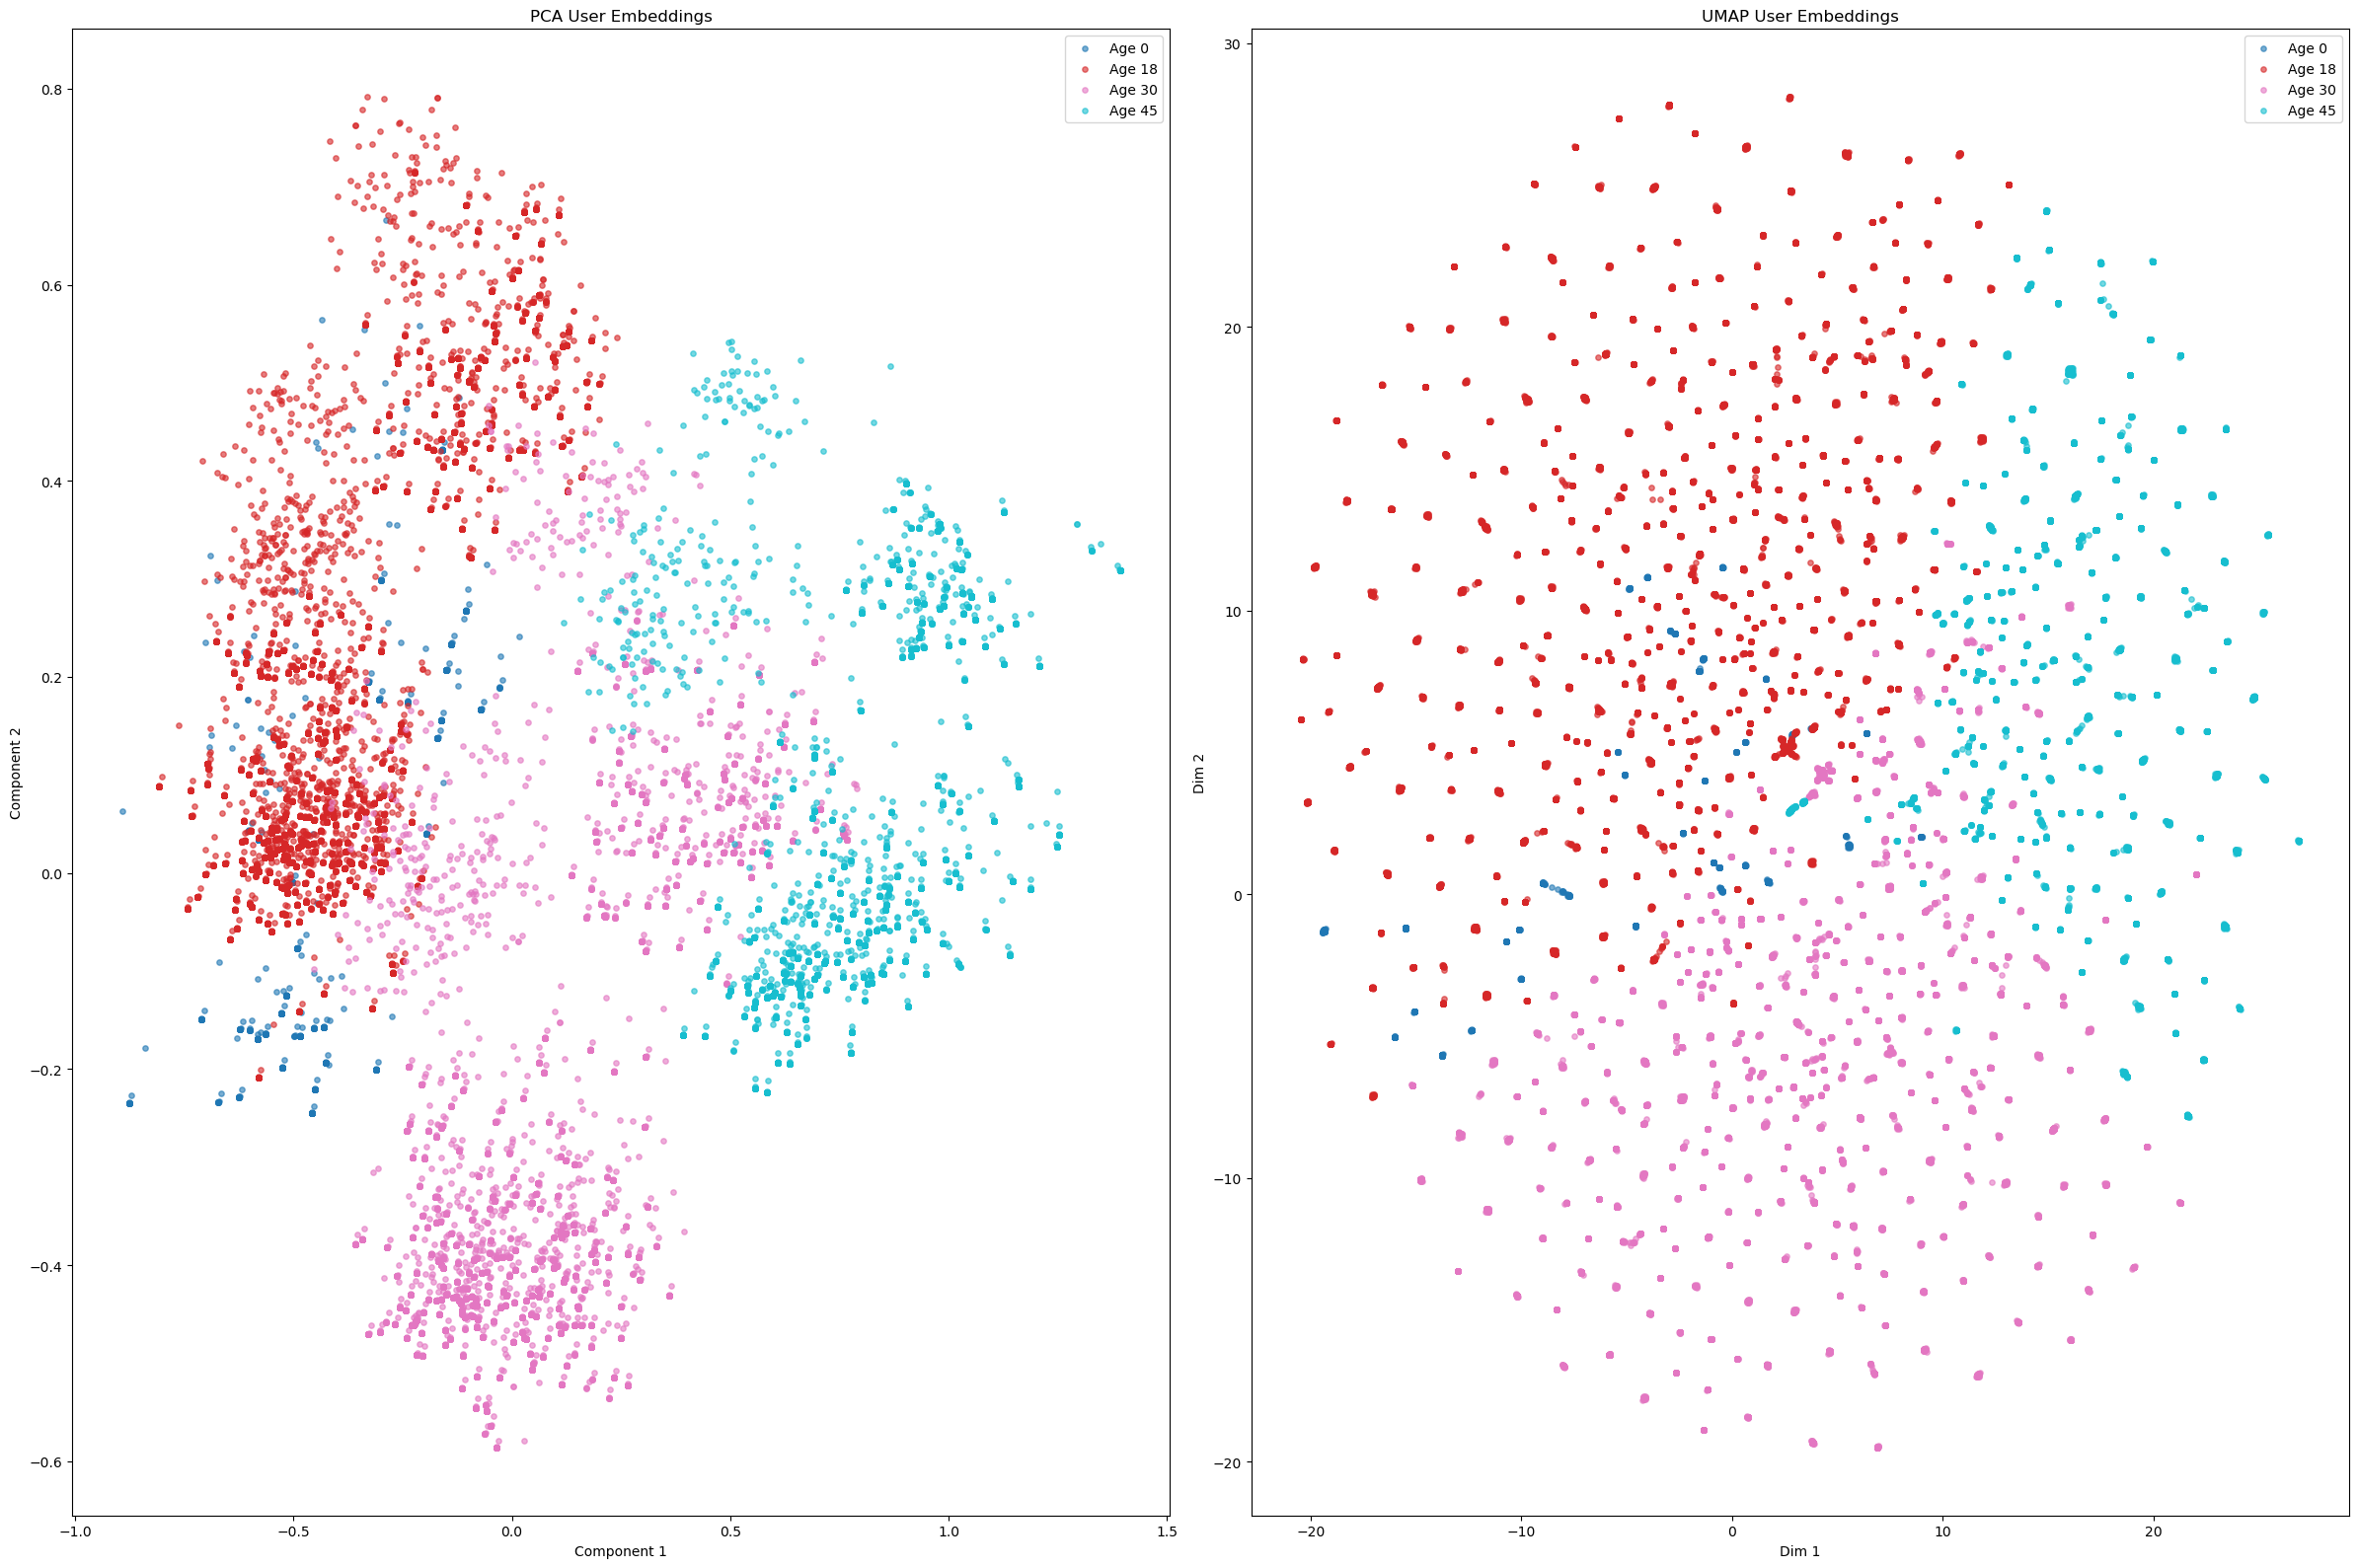

In [ ]:
#makes the most sense to color by age_group
age_groups = train_ratings['age_group'].values
unique_age_groups = np.unique(age_groups)
colors = plt.cm.get_cmap('tab10')(np.linspace(0, 1, len(unique_age_groups)))


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 16))

for i, age_group in enumerate(unique_age_groups):
    idx = age_groups == age_group
    ax1.scatter(user_pca[idx, 0], user_pca[idx, 1], 
                color=colors[i], label=f'Age {age_group}', alpha=0.6, s=15)
    ax2.scatter(user_umap[idx, 0], user_umap[idx, 1],
                color=colors[i], label=f'Age {age_group}', alpha=0.6, s=15)

ax1.legend()
ax1.set_title("PCA User Embeddings")
ax1.set_xlabel("Component 1")
ax1.set_ylabel("Component 2")

ax2.legend()
ax2.set_title("UMAP User Embeddings")
ax2.set_xlabel("Dim 1")
ax2.set_ylabel("Dim 2")

plt.tight_layout()
plt.show()

The users are definitely well embedded, there are clear regions in both PCA and UMAP

In [ ]:

#Now do actual collaborative filter, model interactions of user-rating with movies


movie_emb_input = Input(shape=(embedding_dim,), name='movie_embedding')

#combine user embedding with movie embedding
interaction = Concatenate()([user_final_emb, movie_emb_input])
x = Dense(64, activation='relu')(interaction)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
rating_output = Dense(1, activation='linear', name='rating')(x)
# Clip values between 1-5 instead of using sigmoid scaling
rating_output = Lambda(lambda x: tf.clip_by_value(x, 1.0, 5.0))(rating_output)

# Build model
model = Model(
    inputs=[user_id_input, user_seq_input, user_demo_input, movie_emb_input],
    outputs=rating_output
)

# Compile
model.compile(optimizer='adam', loss='mse')

history = model.fit(
    x=[
        train_data['user_id'],
        train_data['user_seq'],
        train_data['user_demo'],
        train_data['movie_emb']
    ],
    y=train_data['targets'],
    validation_data=([
        val_data['user_id'],
        val_data['user_seq'],
        val_data['user_demo'],
        val_data['movie_emb']
    ], val_data['targets']),
    epochs=2,
    batch_size=32
)

NameError: name 'embedding_dim' is not defined

2025-05-20 20:58:34.969610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-05-20 20:58:34.973649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-05-20 20:58:34.975613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

248/248 [==============================] - 23s 88ms/step
Results on test:
RMSE: 1.1254
MAE: 0.9440
R2 Score: -0.0030
Bias: 0.0101


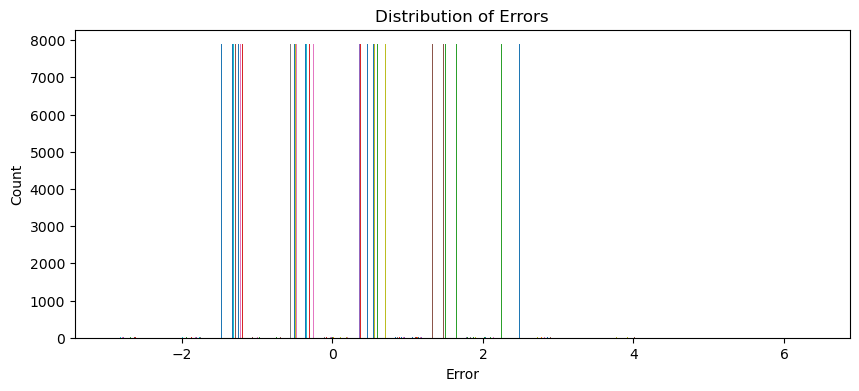

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

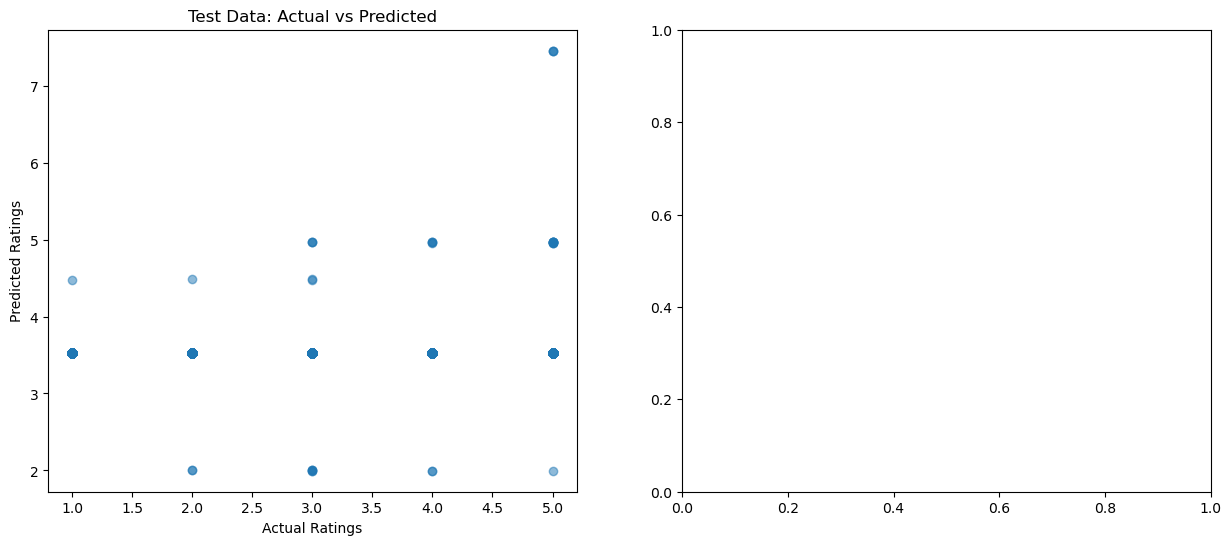

In [ ]:
#Evalu on test_data
test_predictions = model.predict([
    test_data['user_id'],
    test_data['user_seq'],
    test_data['user_demo'],
    test_data['movie_emb']
])

In [ ]:
print("Results on test:")
evaluate_predictions(test_data['targets'], test_predictions)

plt.figure(figsize=(10, 6))
plt.scatter(test_demo_data['targets'], test_predictions, alpha=0.5)
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Test Data: Actual vs Predicted')
plt.tight_layout()
plt.show()

In [ ]:
test_u1_predictions = model.predict([
    tf.convert_to_tensor(test_demo_data['user_id'], dtype=tf.int32),
    tf.convert_to_tensor(test_demo_data['user_seq'], dtype=tf.float32),
    tf.convert_to_tensor(test_demo_data['user_demo'], dtype=tf.float32),
    tf.convert_to_tensor(test_demo_data['movie_emb'], dtype=tf.float32)
])



625/625 [==============================] - 132s 211ms/step



Results on test_demo_data:
RMSE: 1.1543
MAE: 0.9681
R2 Score: -0.0011
Bias: -0.0093


KeyboardInterrupt: 

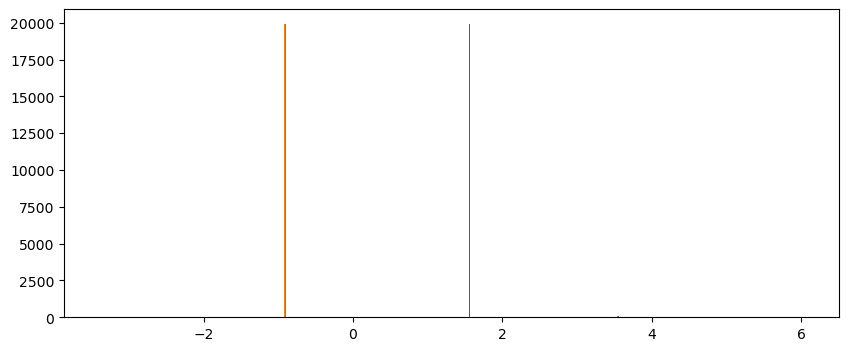

In [ ]:
print("\nResults on test_demo_data:")
evaluate_predictions(test_demo_data['targets'], test_u1_predictions)

plt.figure(figsize=(10, 6))
plt.scatter(test_demo_data['targets'], test_u1_predictions, alpha=0.5)
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Test U1 Data: Actual vs Predicted')
plt.tight_layout()
plt.show()

In [ ]:
#Return to matrix based

import implicit
import scipy.sparse as sparse

def prepare_als_data(ratings_df, movies_df, n_factors=64):
    #sparse rating matrix
    user_ids = ratings_df['userId'].unique()
    movie_ids = movies_df['movieId'].unique()
    
    user_map = {uid: idx for idx, uid in enumerate(user_ids)}
    movie_map = {mid: idx for idx, mid in enumerate(movie_ids)}
    
    #Map IDs to matrix indices
    row = [user_map[uid] for uid in ratings_df['userId']]
    col = [movie_map[mid] for mid in ratings_df['movieId']]
    data = ratings_df['rating'].values
    
    # Create matrix
    ratings_sparse = sparse.csr_matrix(
        (data, (row, col)), 
        shape=(len(user_ids), len(movie_ids))
    )
    
    # Get numerics and one-hot encoded features
    numeric_cols = ['revenue_norm', 'runtime', 'budget_norm', 'popularity_norm',
                   'vote_average', 'weighted_average_vote', 'mean_vote', 'median_vote']
    #genres
    
    # Standardize numerics
    scaler = StandardScaler()
    movie_features = movies_df[numeric_cols].copy()
    movie_features[numeric_cols] = scaler.fit_transform(movie_features[numeric_cols])
    
    #Add genre features
    movie_features = pd.concat([movie_features, movies_df[genres]], axis=1)
    
    #Convert to sparse
    movie_features_sparse = sparse.csr_matrix(movie_features.values)
    
    # Get relevant user features
    user_features = pd.get_dummies(ratings_df[['gender', 'state', 'age_group', 'occupation']])
    user_features['age_scaled'] = StandardScaler().fit_transform(ratings_df[['age']])
    user_features_sparse = sparse.csr_matrix(user_features.values)
    
    return (ratings_sparse, movie_features_sparse, user_features_sparse, 
            user_map, movie_map, user_ids, movie_ids)


In [ ]:
# Train Alternating least squares
def train_als_model(ratings_sparse, movie_features_sparse, user_features_sparse, 
                    n_factors=64, regularization=0.1, alpha=40):
    
    # Initialize ALS model
    model = implicit.als.AlternatingLeastSquares(
        factors=n_factors,
        regularization=regularization,
        iterations=50,
        alpha=alpha
    )
    
    #convert into confidence matrix
    confidence = (ratings_sparse * alpha).astype('double')
    
    model.fit(confidence)
    
    # embeddings
    user_factors = model.user_factors
    item_factors = model.item_factors
    
    # generate biases ofr side features
    user_bias = sparse.linalg.norm(user_features_sparse, axis=1).reshape(-1, 1)
    item_bias = sparse.linalg.norm(movie_features_sparse, axis=1).reshape(-1, 1)
    
    # Adjust embeddings accordingly
    user_factors = user_factors * (1 + 0.1 * user_bias)
    item_factors = item_factors * (1 + 0.1 * item_bias)
    
    return model, user_factors, item_factors

# Make predictions
def predict_ratings(user_id, movie_ids, model, user_factors, item_factors,
                   user_map, movie_map):
    user_idx = user_map[user_id]
    movie_indices = [movie_map[mid] for mid in movie_ids]
    
    user_embedding = user_factors[user_idx]
    movie_embeddings = item_factors[movie_indices]
    
    # Calculate similarity by dot product for predictions
    predictions = np.dot(user_embedding, movie_embeddings.T)
    
    #scale 1-5
    predictions = (predictions - predictions.min()) / (predictions.max() - predictions.min()) * 4 + 1
    
    return predictions

In [ ]:

(ratings_sparse, movie_features_sparse, user_features_sparse,
 user_map, movie_map, user_ids, movie_ids) = prepare_als_data(ratings_with_demographics, merged_with_ratings)

model, user_factors, item_factors = train_als_model(ratings_sparse, movie_features_sparse, user_features_sparse)

test_als_predictions = []
test_als_actuals = []

for _, row in test_ratings.iterrows():
    pred = predict_ratings(
        row['userId'], 
        [row['movieId']], 
        model, 
        user_factors, 
        item_factors,
        user_map, 
        movie_map
    )[0]
    test_als_predictions.append(pred)
    test_als_actuals.append(row['rating'])

#eval!
evaluate_predictions(test_als_actuals, test_als_predictions)

In [ ]:
#to test on u1.data:

u1_als_predictions = []
u1_als_actuals = []

for _, row in test_ratings_with_demographics.iterrows():
    try:
        pred = predict_ratings(
            row['userId'], 
            [row['movieId']], 
            model, 
            user_factors, 
            item_factors,
            user_map, 
            movie_map
        )[0]
        u1_als_predictions.append(pred)
        u1_als_actuals.append(row['rating'])
    except KeyError:
        #no fallback, skip if user/movie not in training data
        continue

# Evaluate results
print("\nResults on U1.test:")
evaluate_predictions(u1_als_actuals, u1_als_predictions)

# Visualize predictions
plt.figure(figsize=(10, 6))
plt.scatter(u1_als_actuals, u1_als_predictions, alpha=0.5)
plt.plot([1, 5], [1, 5], 'r--')  # diagonal line
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Test U1.test: ALS Actual vs Predicted')
plt.tight_layout()
plt.show()